In [1]:
import os
import sys

data_path = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if data_path not in sys.path:
    sys.path.append(data_path)

print("Final sys.path:", sys.path)

Final sys.path: ['/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/test/test_chronos', '/opt/anaconda3/lib/python312.zip', '/opt/anaconda3/lib/python3.12', '/opt/anaconda3/lib/python3.12/lib-dynload', '', '/opt/anaconda3/lib/python3.12/site-packages', '__editable__.lag_llama-0.1.0.finder.__path_hook__', '/opt/anaconda3/lib/python3.12/site-packages/aeosa', '/opt/anaconda3/lib/python3.12/site-packages/setuptools/_vendor', '/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial']


In [9]:
!pwd

/Users/anthonybolton/Developer/FYP/ts-fm-benchmark-financial/test/test_chronos


In [1]:
# Add this at the top of your notebook
%config InteractiveShell.cache_size = 0

In [2]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-iw77s2nb
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /private/var/folders/x3/lq5xm_7n0p34sd9k354_nyjh0000gn/T/pip-req-build-iw77s2nb
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit f40a266a550e37ac16cb6c46dd29a6183f39f618
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


# Forecasting visualization function

In [3]:
import matplotlib.pyplot as plt

# ======================
# Finalized Forecasting Plot Function
# ======================

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 400
plt.rcParams["figure.figsize"] = (14, 8)

custom_palette = {
    "historical": "#333333",           # dark grey 
    "ground_truth": "#0077CC",         # bright blue 
    "forecast": "#FFA500",             # orange
    "prediction_interval": "#FF7F0E",  # bright orange
}


def plot_forecasts(data, start_idx, forecasts, method, historical_window, FORECAST_STEPS):
    """Plot forecasting results with historical data, ground truth, and model predictions."""

    fig, ax = plt.subplots()

    # Historical data (context window before forecast start)
    context_data = data.iloc[start_idx - historical_window : start_idx + 1]
    ax.plot(
        context_data["Date"],
        context_data["Close"],
        label="Historical Data",
        color=custom_palette["historical"],
        linewidth=1.75,
    )

    # Ground truth for the forecast period
    actual_data = data.iloc[start_idx : start_idx + FORECAST_STEPS]
    ax.plot(
        actual_data["Date"],
        actual_data["Close"],
        label="Ground Truth",
        color=custom_palette["ground_truth"],
        linewidth=1.75,
    )

    # Forecast median and uncertainty band
    ax.plot(
        forecasts["dates"],
        forecasts["median"],
        label=f"Prediction",
        color=custom_palette["forecast"],
        linewidth=1.75,
    )
    ax.fill_between(
        forecasts["dates"],
        forecasts["low"],
        forecasts["high"],
        color=custom_palette["forecast"],
        alpha=0.4,
    )

    # Labels and title
    ax.set_xlabel("Time", fontsize=12)
    ax.set_ylabel("Value", fontsize=12)
    ax.set_title(
        f"{method}",
        fontsize=14,
    )

    # Tick formatting
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(fontsize=10)

    # Legend
    ax.legend(fontsize=10, frameon=True)

    # Grid and layout
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Turn synthetic data into dataframe for feeding into Chronos

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def convert_synthetic_to_dataframe(synthetic_data):
    """
    Convert synthetic data to a DataFrame with Date and Close columns
    
    Args:
        synthetic_data: Output from generator's generate() method
                      (can be array or tuple with (array, time_features))
    """
    # Handle ARNonstationaryGenerator which returns a tuple of (data, time_features)
    if isinstance(synthetic_data, tuple):
        # Extract just the data array and ignore time features
        series = synthetic_data[0][0]  
    else:
        # For other generators that return just the array
        series = synthetic_data[0]
    
    # Create dates (daily, starting from today going backwards)
    end_date = datetime.now()
    dates = [end_date - timedelta(days=i) for i in range(len(series))]
    dates.reverse()  # So they go from past to present
    
    # Create DataFrame with Date and Close columns
    df = pd.DataFrame({
        'Date': dates,
        'Close': series
    })
    
    return df

## Chronos one-step sliding window

In [5]:
import pandas as pd
import numpy as np
import torch
from chronos import ChronosPipeline
from sklearn.preprocessing import StandardScaler
from utils.metrics import calculate_metrics

# CONTEXT_WINDOW = 100
# FORECAST_STEPS = 21
PREDICTION_INTERVAL_ALPHA = 0.2

# ======================
# Chronos Implementation (Context Scaling)
# ======================
class ChronosPredictor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-large",
            device_map="mps",
            torch_dtype=torch.bfloat16,
        )
        
    def generate_single_forecast(self, context_data):
        # Fit scaler on context window
        self.scaler.fit(context_data.reshape(-1, 1))
        scaled_data = self.scaler.transform(context_data.reshape(-1, 1)).flatten()
        context = torch.tensor(scaled_data, dtype=torch.bfloat16)
        
        forecast = self.pipeline.predict(context, 1)
        forecast_np = forecast[0].cpu().numpy()
        
        forecast_original = self.scaler.inverse_transform(forecast_np.reshape(-1, 1))
        return (
            np.quantile(forecast_original, 0.1).item(),
            np.quantile(forecast_original, 0.5).item(),
            np.quantile(forecast_original, 0.9).item()
        )

    def sliding_window_forecast(self, full_data, start_idx, CONTEXT_WINDOW, FORECAST_STEPS):
        forecasts = {'median': [], 'low': [], 'high': [], 'dates': []}
        
        for i in range(FORECAST_STEPS):
            current_idx = start_idx + i
            context_start = current_idx - CONTEXT_WINDOW
            context_data = full_data['Close'].iloc[context_start:current_idx].values
            
            low, median, high = self.generate_single_forecast(context_data)
            forecasts['dates'].append(full_data['Date'].iloc[current_idx])
            forecasts['median'].append(median)
            forecasts['low'].append(low)
            forecasts['high'].append(high)
            
        return forecasts

# ======================
# Multiple Trials Comparison (Chronos Only)
# ======================
def run_multiple_trials_comparison(full_data, n_trials=10, test_start=None, CONTEXT_WINDOW=None, FORECAST_STEPS=None):
    """Run trials for Chronos model with consistent context window scaling approach."""
    
    # Actual data over the forecast horizon
    actual = full_data['Close'].iloc[test_start : test_start + FORECAST_STEPS].values

    # Get the last historical point for directional accuracy calculation
    historical_last_point = float(full_data['Close'].iloc[test_start - 1]) if test_start > 0 else None

    # In-sample data (used for metric calculation)
    insample_data = full_data['Close'].iloc[test_start - CONTEXT_WINDOW : test_start].values
    
    # Chronos Context Window Scaling
    chronos_context = ChronosPredictor()
    chronos_context_metrics_list = []
    chronos_context_preds = None
    
    for trial in range(n_trials):
        chronos_context_preds = chronos_context.sliding_window_forecast(full_data, test_start, CONTEXT_WINDOW, FORECAST_STEPS)
        
        # Ensure predictions align with actual values
        if len(chronos_context_preds['median']) != len(actual):
            print(f"Warning: Chronos prediction length ({len(chronos_context_preds['median'])}) doesn't match actual data length ({len(actual)})")
            min_length = min(len(chronos_context_preds['median']), len(actual))
            chronos_actual = actual[:min_length]
            chronos_preds = chronos_context_preds['median'][:min_length]
        else:
            chronos_actual = actual
            chronos_preds = chronos_context_preds['median']
        
        chronos_metrics = calculate_metrics(
            chronos_actual, 
            chronos_preds, 
            insample=insample_data,
            historical_last_point=historical_last_point,
            directional_accuracy=True
        )
        
        chronos_context_metrics_list.append(chronos_metrics)
        
        print(f"\nTrial {trial+1}/{n_trials}")
        print("Context scaling metrics:", chronos_metrics)
    
    # Average & std for Chronos Context
    chronos_context_avg = {
        metric: np.mean([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    chronos_context_std = {
        metric: np.std([m[metric] for m in chronos_context_metrics_list]) 
        for metric in chronos_context_metrics_list[0]
    }
    
    return (
        chronos_context_avg,
        chronos_context_std,
        chronos_context_preds
    )

# 1. Stationary: Simple Sine Wave


Trial 1/5
Context scaling metrics: {'MAE': 0.004032113830887822, 'MSE': 2.1521785256682544e-05, 'RMSE': 0.004639157817608983, 'Z-NormalizedMAE': 0.005167577416983581, 'Z-NormalizedMSE': 3.5349779452543535e-05, 'Z-NormalizedRMSE': 0.005945568051291947, 'MAPE': 1.0609735389877795, 'SMAPE': 1.059414666028648, 'MASE': 0.018618667028624657, 'DirectionalAccuracy': 100.0}

Trial 2/5
Context scaling metrics: {'MAE': 0.00420025153912401, 'MSE': 2.218883373895408e-05, 'RMSE': 0.004710502493254205, 'Z-NormalizedMAE': 0.005383063551667776, 'Z-NormalizedMSE': 3.644541424543931e-05, 'Z-NormalizedRMSE': 0.006037003747343487, 'MAPE': 1.078258312822423, 'SMAPE': 1.0766427699143108, 'MASE': 0.019395058801253837, 'DirectionalAccuracy': 100.0}

Trial 3/5
Context scaling metrics: {'MAE': 0.004153752719292305, 'MSE': 2.195127901918322e-05, 'RMSE': 0.004685219207164508, 'Z-NormalizedMAE': 0.005323470429708271, 'Z-NormalizedMSE': 3.605522789000193e-05, 'Z-NormalizedRMSE': 0.0060046005604038255, 'MAPE': 1.073

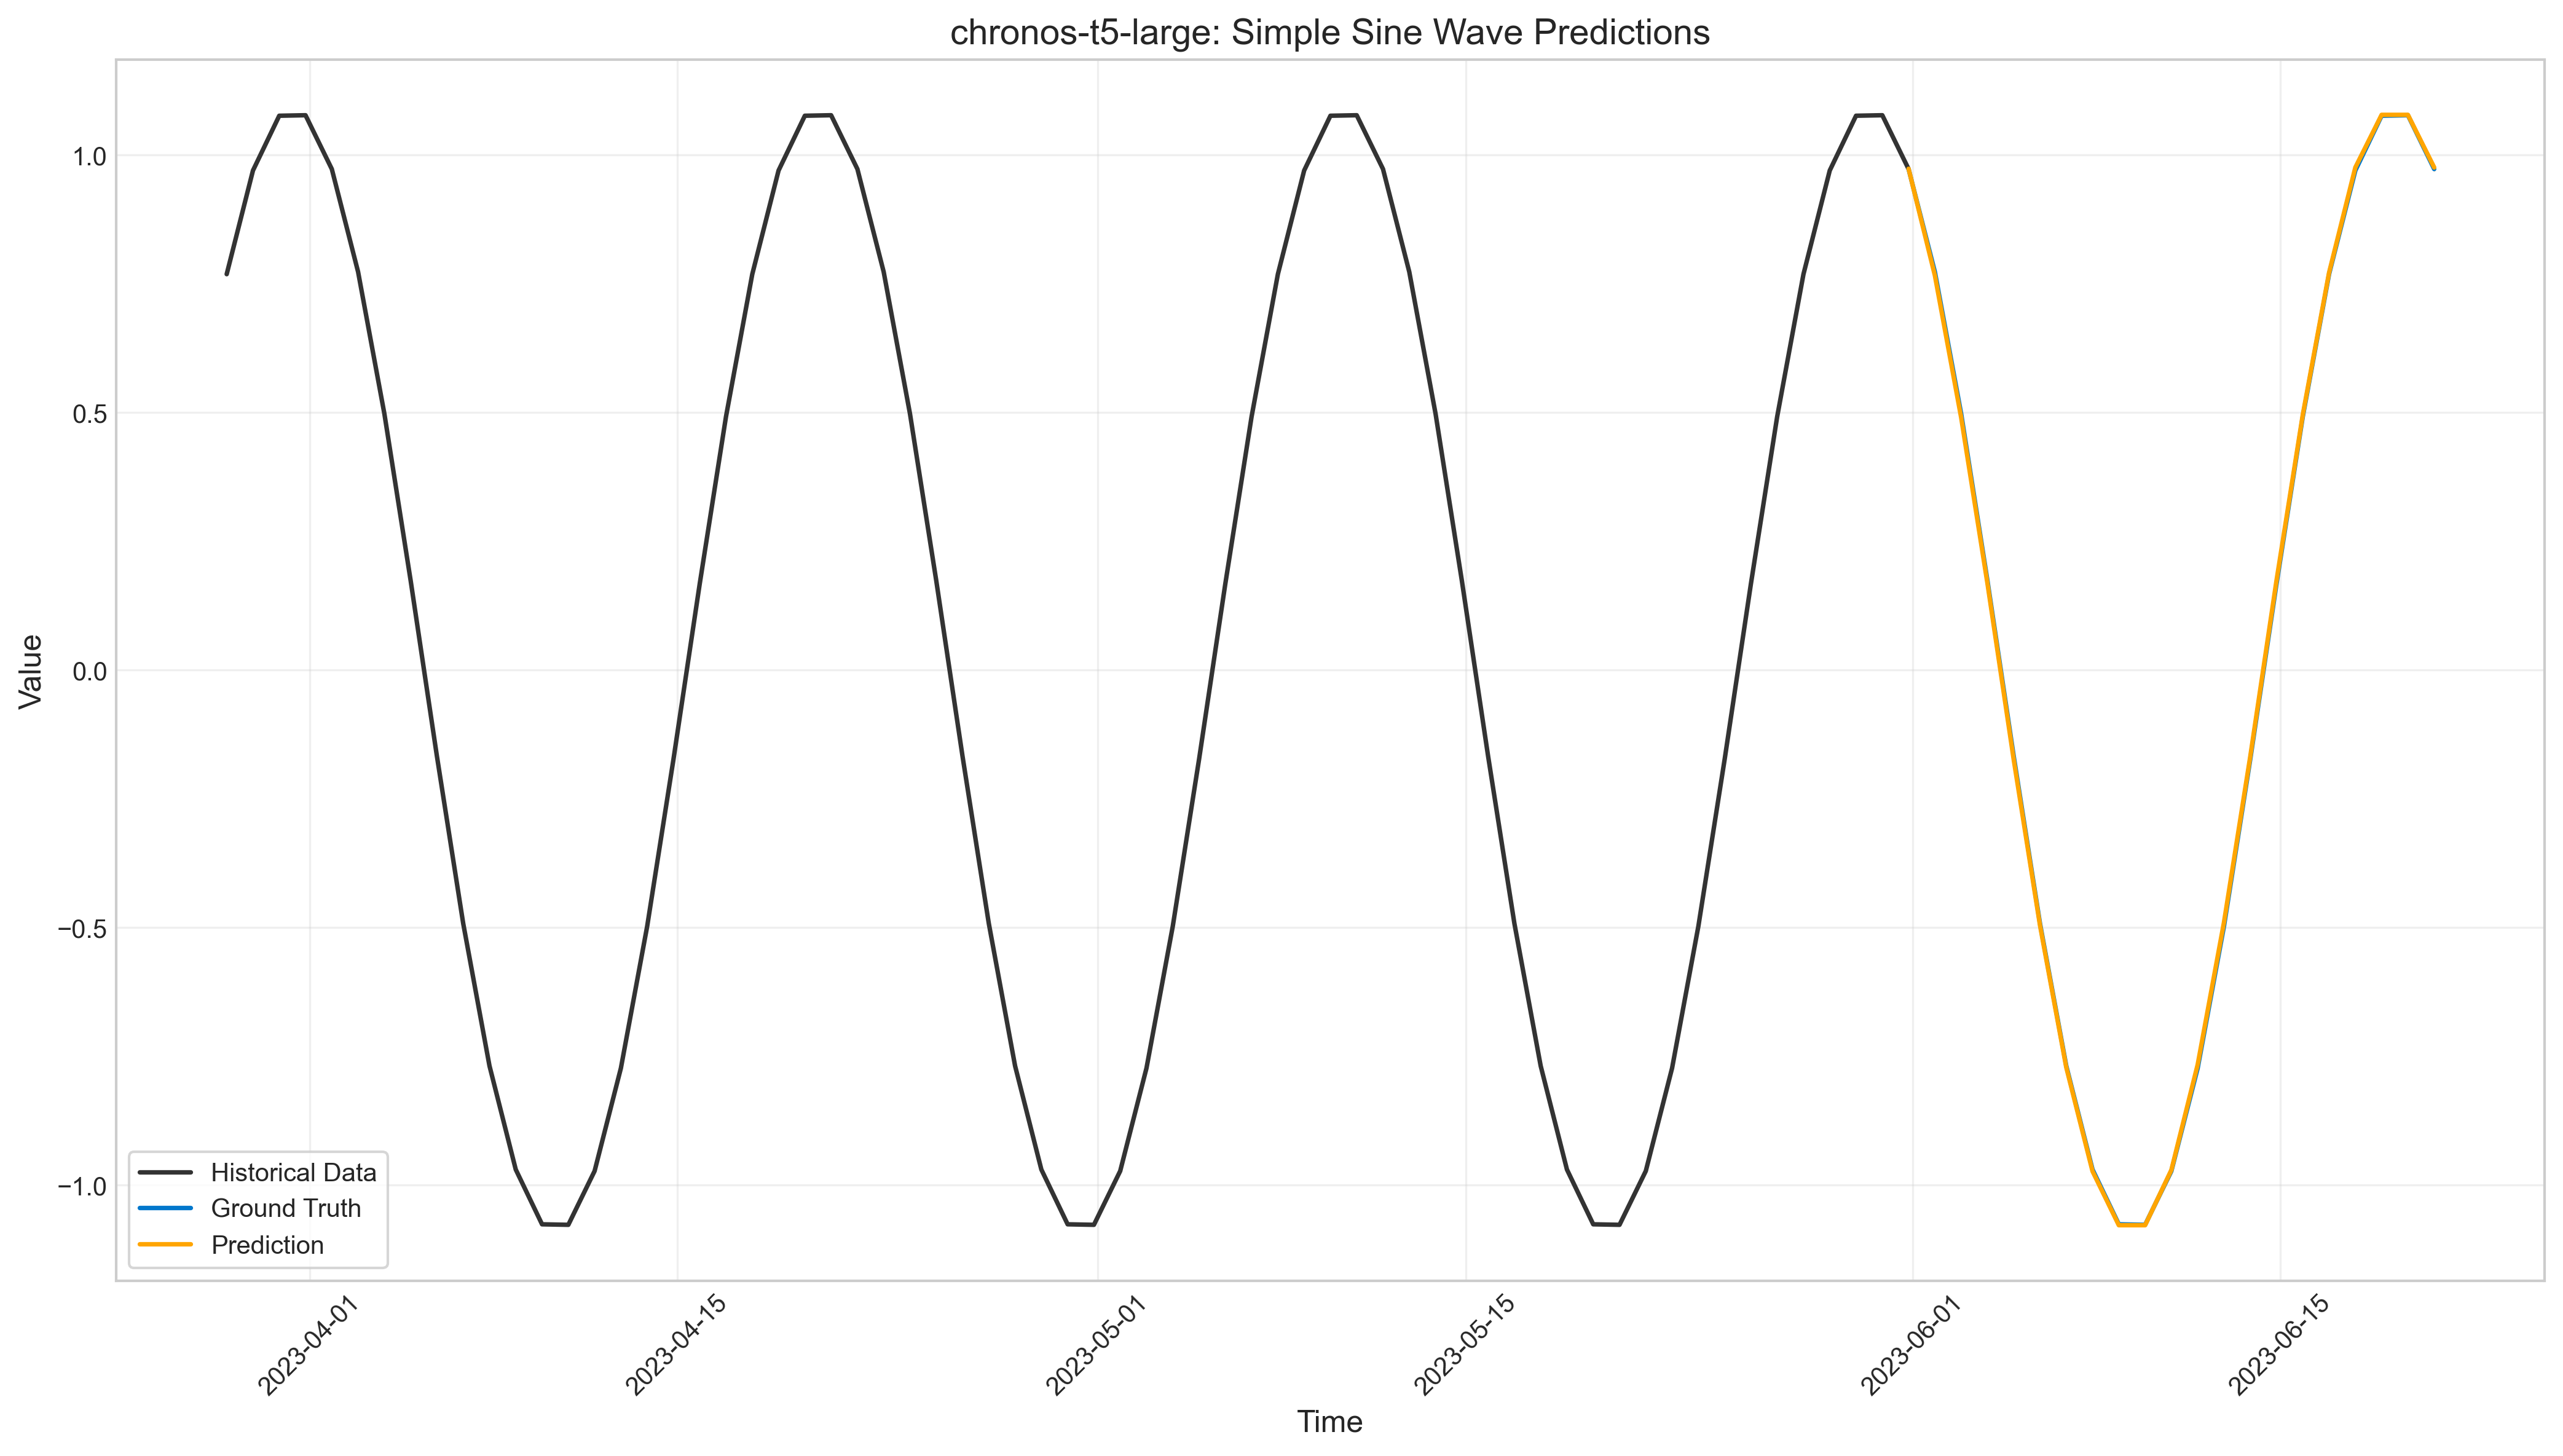

In [9]:
from data.synthetic.stationary import SineWaveGenerator

sine_gen = SineWaveGenerator(
    seq_length=2000,
    num_samples=1,
    freq=0.05,
    amplitude=1.0
)
sine_data = sine_gen.generate()

sine_df = convert_synthetic_to_dataframe(sine_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_sinedf = sine_df[sine_df['Date'] <= test_date].index
test_start = date_indices_sinedf[-1]

# Run Chronos comparison
sinedf_chronos_context_avg, sinedf_chronos_context_std, sinedf_chronos_context_preds = run_multiple_trials_comparison(
    sine_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=64,
    FORECAST_STEPS=21
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in sinedf_chronos_context_avg:
    print(f"{metric}: {sinedf_chronos_context_avg[metric]:.4f} ± {sinedf_chronos_context_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(sine_df, test_start, sinedf_chronos_context_preds, "chronos-t5-large: Simple Sine Wave Predictions", historical_window=64, FORECAST_STEPS=21)

## Note: choosing a good context window length matters, with wrong window length, even sine wave cannot be predicted optimally. Below we perform one-step predictions with context window of length 10, which is still context window > prediction window, but perfomance degrades:


Trial 1/5
Context scaling metrics: {'MAE': 0.09793014319995735, 'MSE': 0.013544354920502539, 'RMSE': 0.11638021704955932, 'Z-NormalizedMAE': 0.12451858668170755, 'Z-NormalizedMSE': 0.021897468581206295, 'Z-NormalizedRMSE': 0.1479779327508203, 'MAPE': 27.343207418218572, 'SMAPE': 29.464051747333357, 'MASE': 0.409286456746001, 'DirectionalAccuracy': 94.44444444444444}

Trial 2/5
Context scaling metrics: {'MAE': 0.08432907242567995, 'MSE': 0.011482411962850348, 'RMSE': 0.10715601692322436, 'Z-NormalizedMAE': 0.10722476830432733, 'Z-NormalizedMSE': 0.018563878211163544, 'Z-NormalizedRMSE': 0.13624932370901346, 'MAPE': 23.403474360853778, 'SMAPE': 26.36853693929434, 'MASE': 0.3524425281734753, 'DirectionalAccuracy': 94.44444444444444}

Trial 3/5
Context scaling metrics: {'MAE': 0.09189835733007512, 'MSE': 0.013057306012176584, 'RMSE': 0.11426856966015013, 'Z-NormalizedMAE': 0.11684914571958346, 'Z-NormalizedMSE': 0.021110045464330183, 'Z-NormalizedRMSE': 0.1452929642630027, 'MAPE': 27.7843

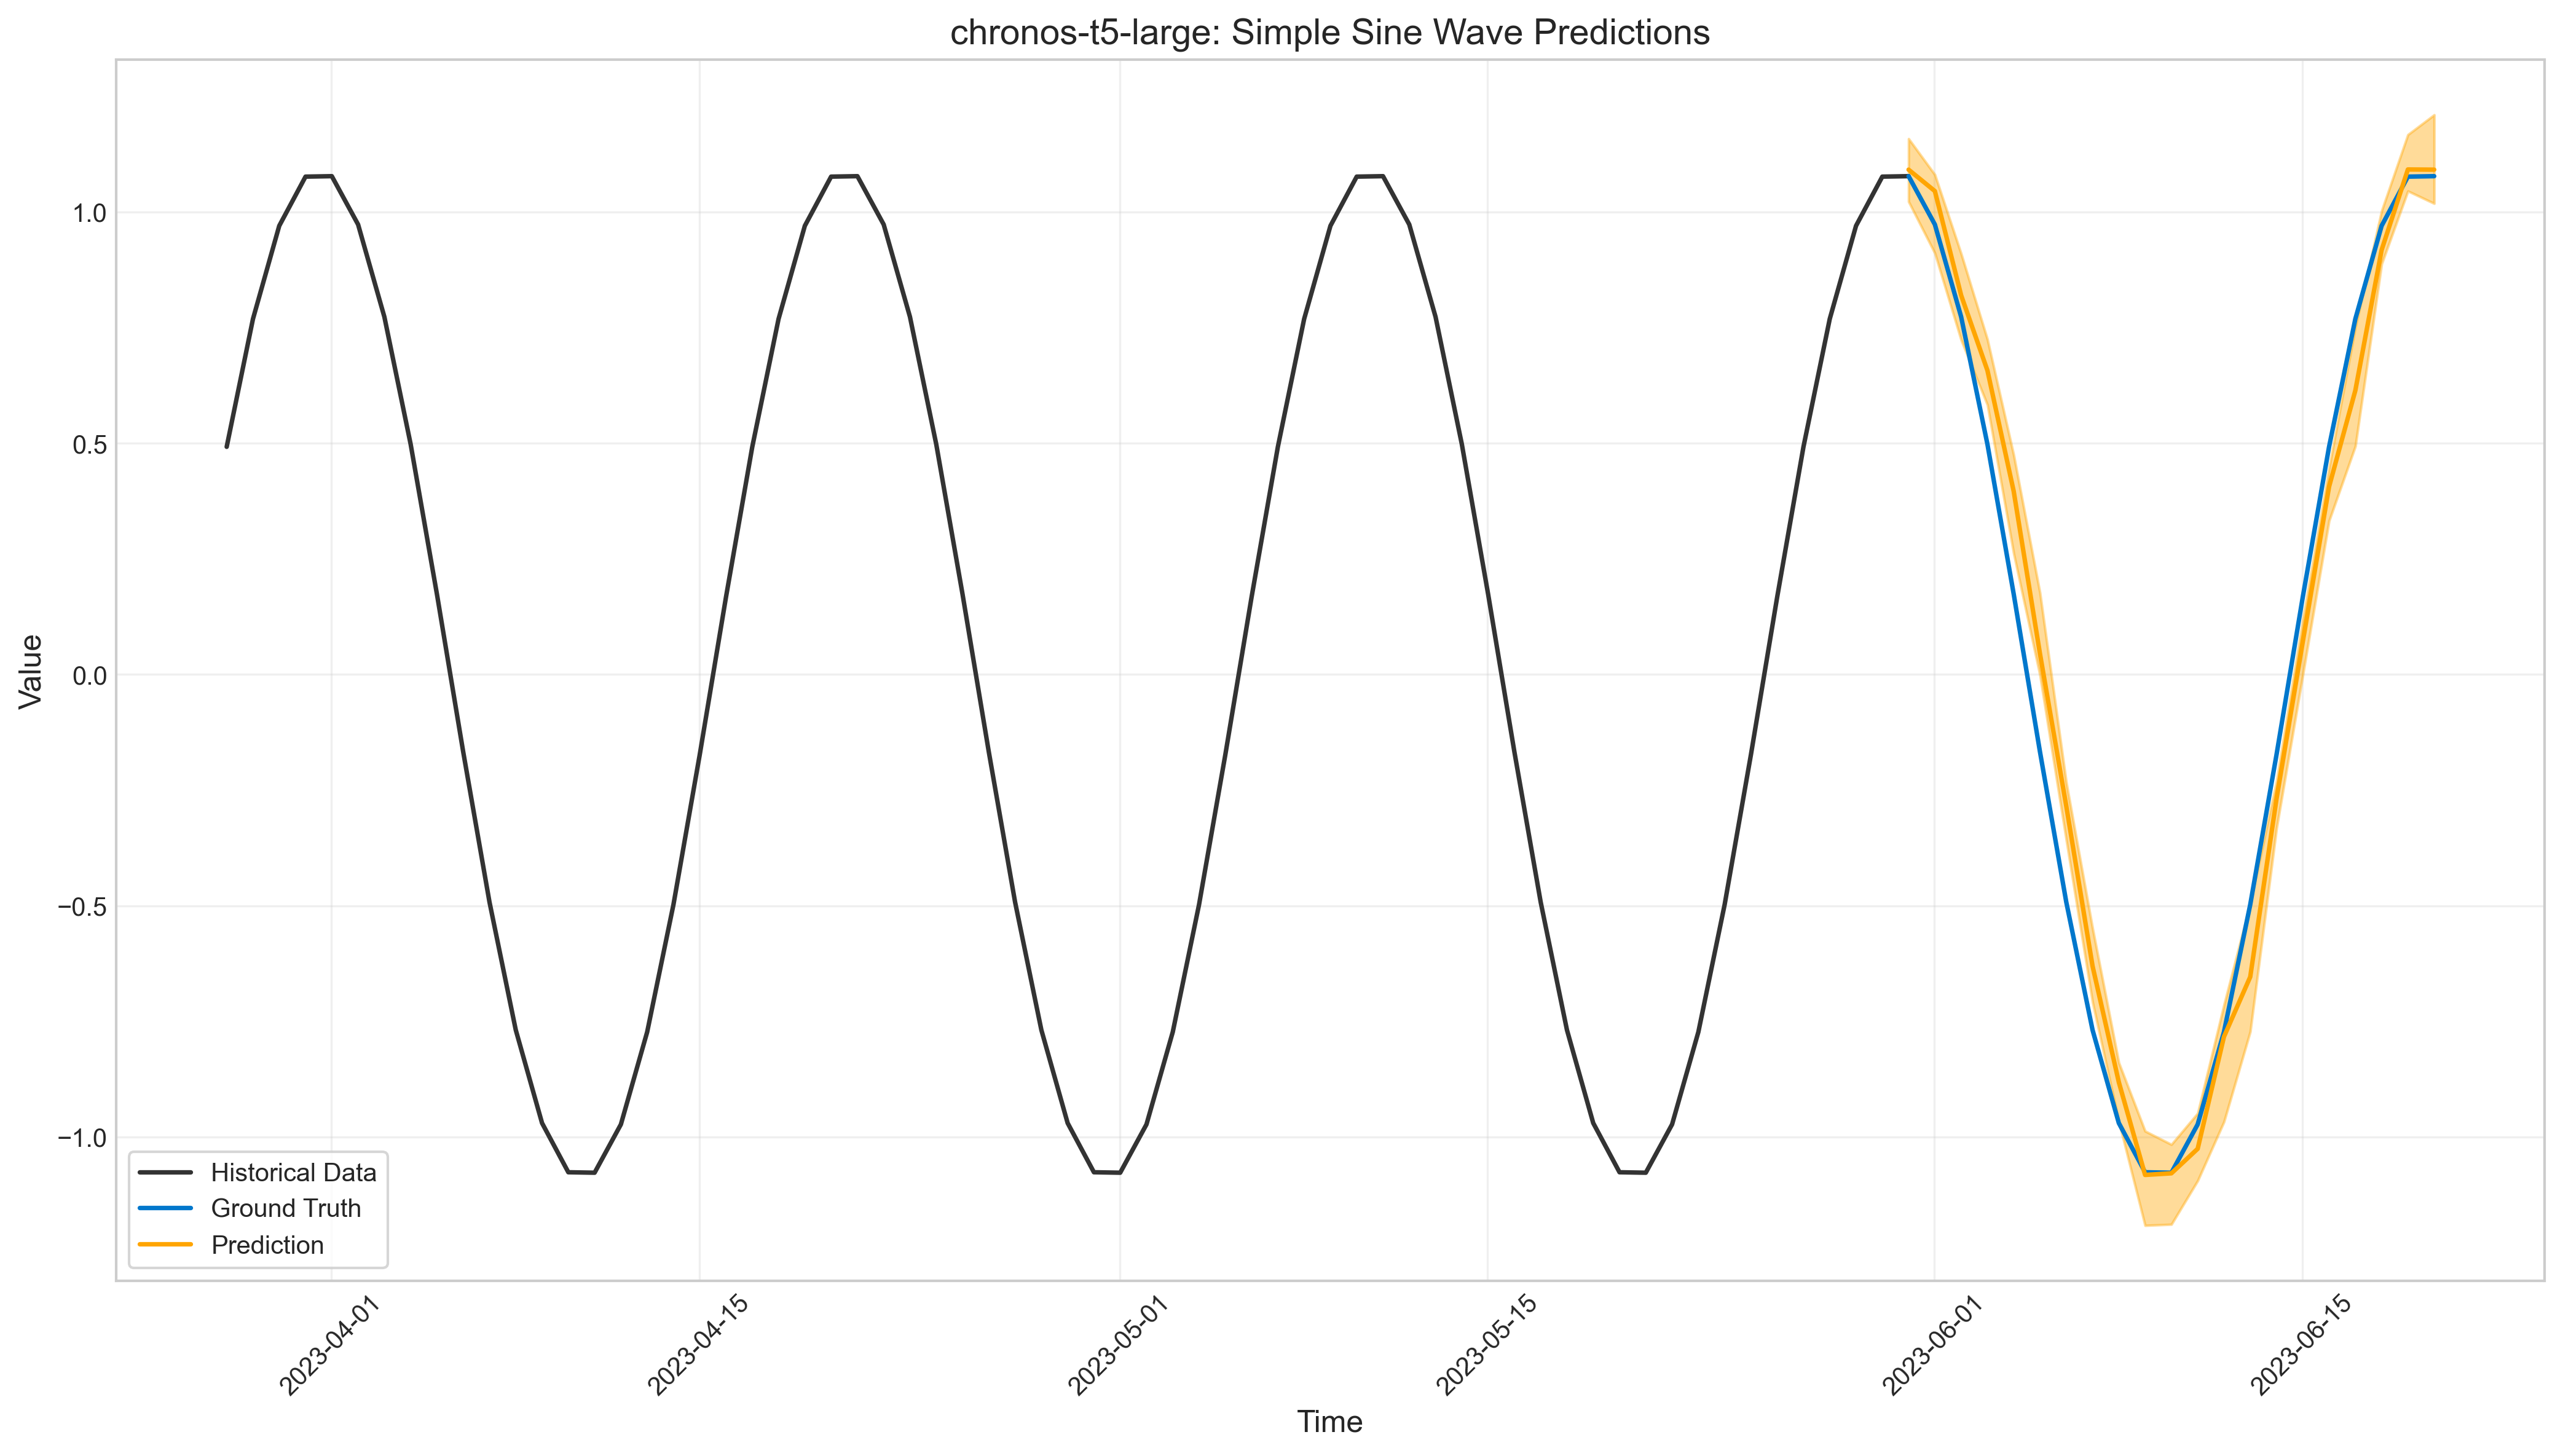

In [21]:
from data.synthetic.stationary import SineWaveGenerator

sine_gen = SineWaveGenerator(
    seq_length=2000,
    num_samples=1,
    freq=0.05,
    amplitude=1.0
)
sine_data = sine_gen.generate()

sine_df = convert_synthetic_to_dataframe(sine_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_sinedf = sine_df[sine_df['Date'] <= test_date].index
test_start = date_indices_sinedf[-1]

# Run Chronos comparison
sinedf_chronos_context_avg, sinedf_chronos_context_std, sinedf_chronos_context_preds = run_multiple_trials_comparison(
    sine_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=10,
    FORECAST_STEPS=21
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in sinedf_chronos_context_avg:
    print(f"{metric}: {sinedf_chronos_context_avg[metric]:.4f} ± {sinedf_chronos_context_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(sine_df, test_start, sinedf_chronos_context_preds, "chronos-t5-large: Simple Sine Wave Predictions", historical_window=64, FORECAST_STEPS=21)

# 2. Stationary: Composite Sine Wave


Trial 1/5
Context scaling metrics: {'MAE': 0.023056696341321382, 'MSE': 0.0009729395458202349, 'RMSE': 0.031191978869899148, 'Z-NormalizedMAE': 0.030546348282449308, 'Z-NormalizedMSE': 0.0017076949514369744, 'Z-NormalizedRMSE': 0.04132426589108359, 'MAPE': 9.58599432775722, 'SMAPE': 12.914937785327652, 'MASE': 0.05665397792735815, 'DirectionalAccuracy': 100.0}

Trial 2/5
Context scaling metrics: {'MAE': 0.024357521465642875, 'MSE': 0.0010126003025761807, 'RMSE': 0.03182138121729132, 'Z-NormalizedMAE': 0.03226972862774501, 'Z-NormalizedMSE': 0.0017773071635967753, 'Z-NormalizedRMSE': 0.04215812096852486, 'MAPE': 12.242284115956895, 'SMAPE': 13.298269031884038, 'MASE': 0.05985031259689126, 'DirectionalAccuracy': 96.66666666666667}

Trial 3/5
Context scaling metrics: {'MAE': 0.028793551042802956, 'MSE': 0.0013319301529776707, 'RMSE': 0.036495618270933165, 'Z-NormalizedMAE': 0.038146741641631655, 'Z-NormalizedMSE': 0.0023377921142974066, 'Z-NormalizedRMSE': 0.048350719894303604, 'MAPE': 1

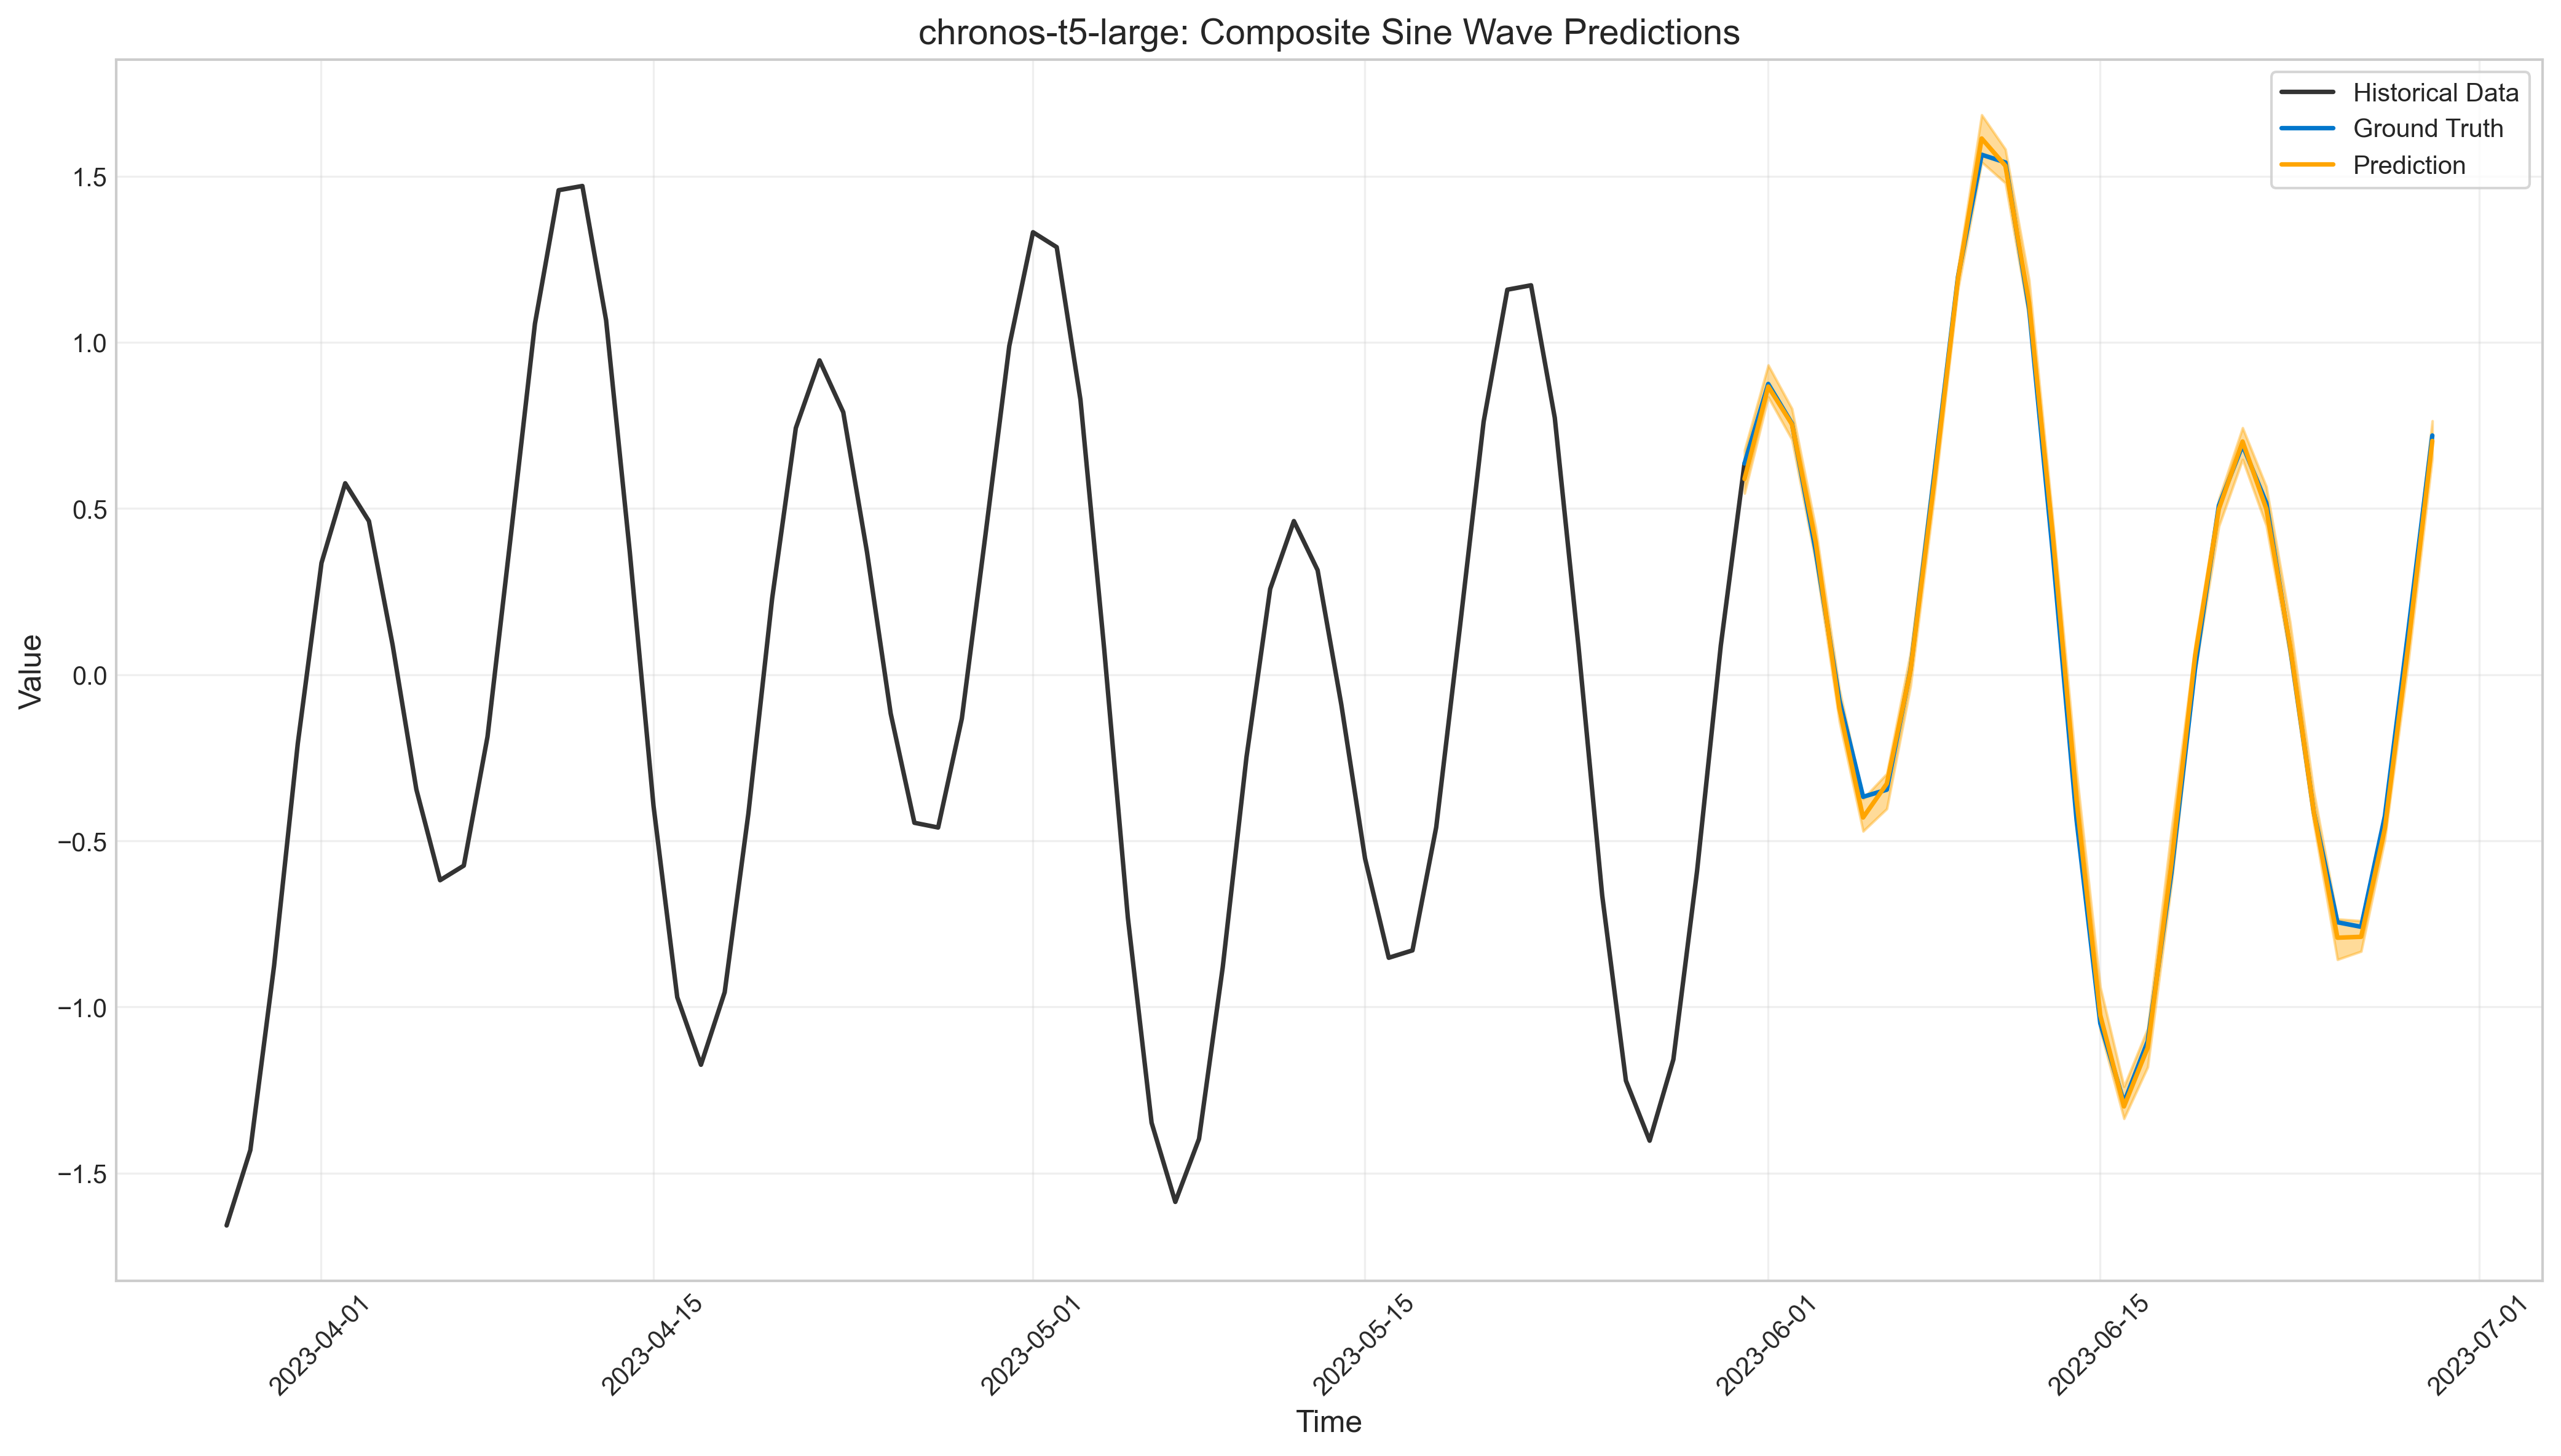

In [18]:
from data.synthetic.stationary import CompositeSineGenerator

comp_sine_gen = CompositeSineGenerator(
    seq_length=2000,
    num_samples=1,
    frequencies=[0.1, 0.05, 0.02],
    amplitudes=[1.0, 0.5, 0.25]
)
comp_sine_data = comp_sine_gen.generate()

comp_sine_df = convert_synthetic_to_dataframe(comp_sine_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_compsinedf = comp_sine_df[comp_sine_df['Date'] <= test_date].index
test_start = date_indices_compsinedf[-1]

# Run Chronos comparison
compsinedf_chronos_context_avg, compsinedf_chronos_context_std, compsinedf_chronos_context_preds = run_multiple_trials_comparison(
    comp_sine_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=65,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in compsinedf_chronos_context_avg:
    print(f"{metric}: {compsinedf_chronos_context_avg[metric]:.4f} ± {compsinedf_chronos_context_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(comp_sine_df, test_start, compsinedf_chronos_context_preds, "chronos-t5-large: Composite Sine Wave Predictions", historical_window=64, FORECAST_STEPS=30)

## 3. Linear Trend


Trial 1/5
Context scaling metrics: {'MAE': 0.08831841864398851, 'MSE': 0.011463837788398708, 'RMSE': 0.1070693130098382, 'Z-NormalizedMAE': 0.12759389401012236, 'Z-NormalizedMSE': 0.023926944768873765, 'Z-NormalizedRMSE': 0.15468336939979607, 'MAPE': 0.6479521523476625, 'SMAPE': 0.6487662290244608, 'MASE': 0.4182598145775744, 'DirectionalAccuracy': 86.66666666666667}

Trial 2/5
Context scaling metrics: {'MAE': 0.08772511860961364, 'MSE': 0.01186508383767524, 'RMSE': 0.10892696561308976, 'Z-NormalizedMAE': 0.12673675160580258, 'Z-NormalizedMSE': 0.024764412311330107, 'Z-NormalizedRMSE': 0.15736712589143292, 'MAPE': 0.6454150708867424, 'SMAPE': 0.646031973068982, 'MASE': 0.41545005455042977, 'DirectionalAccuracy': 83.33333333333334}

Trial 3/5
Context scaling metrics: {'MAE': 0.09154494269295792, 'MSE': 0.01315493961207944, 'RMSE': 0.1146949851217543, 'Z-NormalizedMAE': 0.13225526333541354, 'Z-NormalizedMSE': 0.02745655681334099, 'Z-NormalizedRMSE': 0.1657002016092346, 'MAPE': 0.6693498

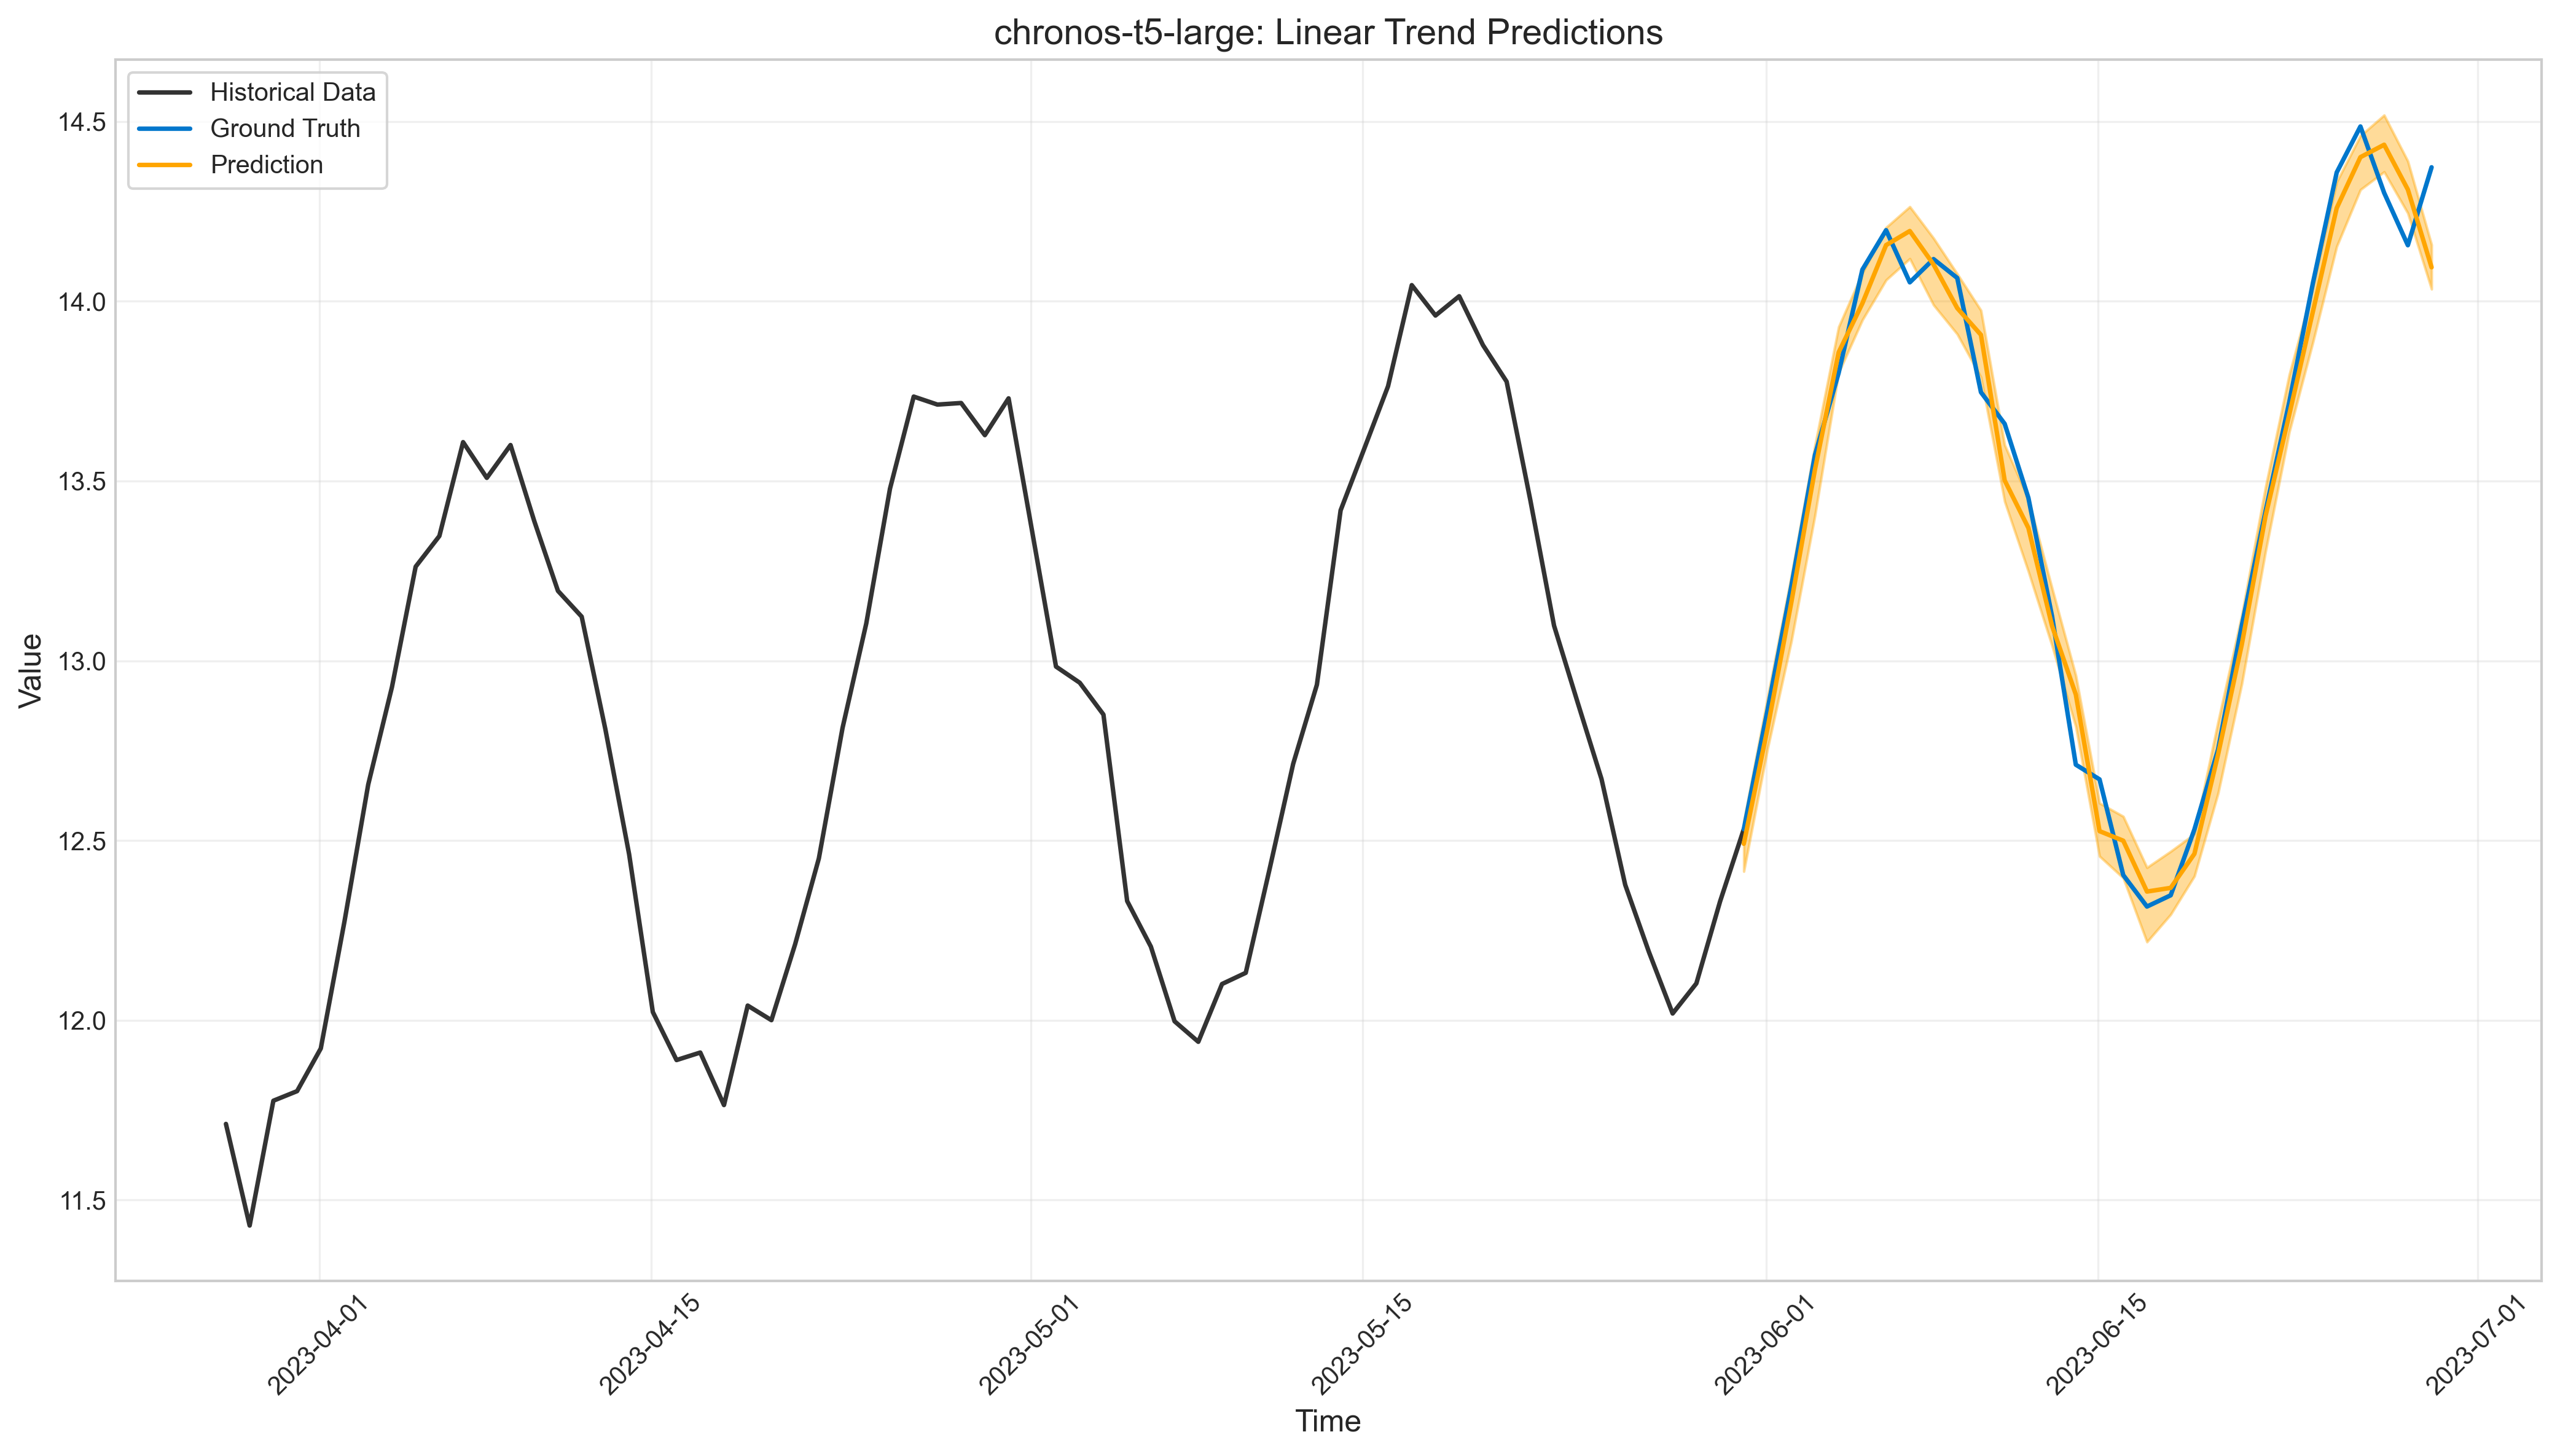

In [22]:
from data.synthetic.nonstationary import TrendGenerator

linear_trend_gen = TrendGenerator(
    seq_length=2000,
    num_samples=1,
    trend_type="linear",
    seasonal_amplitude=1.0,
    trend_coefficient=0.01,
    seed=42,
)
linear_trend_data = linear_trend_gen.generate()

linear_trend_df = convert_synthetic_to_dataframe(linear_trend_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_lineartrendf = linear_trend_df[linear_trend_df['Date'] <= test_date].index
test_start = date_indices_lineartrendf[-1]

# Run Chronos comparison
lineartrend_df_chronos_avg, lineartrend_df_chronos_std, lineartrend_df_chronos_preds = run_multiple_trials_comparison(
    linear_trend_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=70,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in lineartrend_df_chronos_avg:
    print(f"{metric}: {lineartrend_df_chronos_avg[metric]:.4f} ± {lineartrend_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(linear_trend_df, test_start, lineartrend_df_chronos_preds, "chronos-t5-large: Linear Trend Predictions", historical_window=64, FORECAST_STEPS=30)

## 4. Exponential Trend


Trial 1/5
Context scaling metrics: {'MAE': 334.73159916497144, 'MSE': 178699.950502187, 'RMSE': 422.72916921143144, 'Z-NormalizedMAE': 0.006297016466080041, 'Z-NormalizedMSE': 6.324128203295613e-05, 'Z-NormalizedRMSE': 0.007952438747513628, 'MAPE': 0.054922921366287486, 'SMAPE': 0.05494660619372262, 'MASE': 0.0883671810194364, 'DirectionalAccuracy': 100.0}

Trial 2/5
Context scaling metrics: {'MAE': 386.06805749830477, 'MSE': 202121.35142384577, 'RMSE': 449.57908250256236, 'Z-NormalizedMAE': 0.007262764917202251, 'Z-NormalizedMSE': 7.153003318890808e-05, 'Z-NormalizedRMSE': 0.008457542975883013, 'MAPE': 0.06251986125065648, 'SMAPE': 0.06254599138391653, 'MASE': 0.10191970524408434, 'DirectionalAccuracy': 100.0}

Trial 3/5
Context scaling metrics: {'MAE': 317.9940991649715, 'MSE': 163008.27283123767, 'RMSE': 403.7428300679006, 'Z-NormalizedMAE': 0.005982148334825214, 'Z-NormalizedMSE': 5.7688052665124805e-05, 'Z-NormalizedRMSE': 0.007595265147782849, 'MAPE': 0.05188423779360293, 'SMAPE

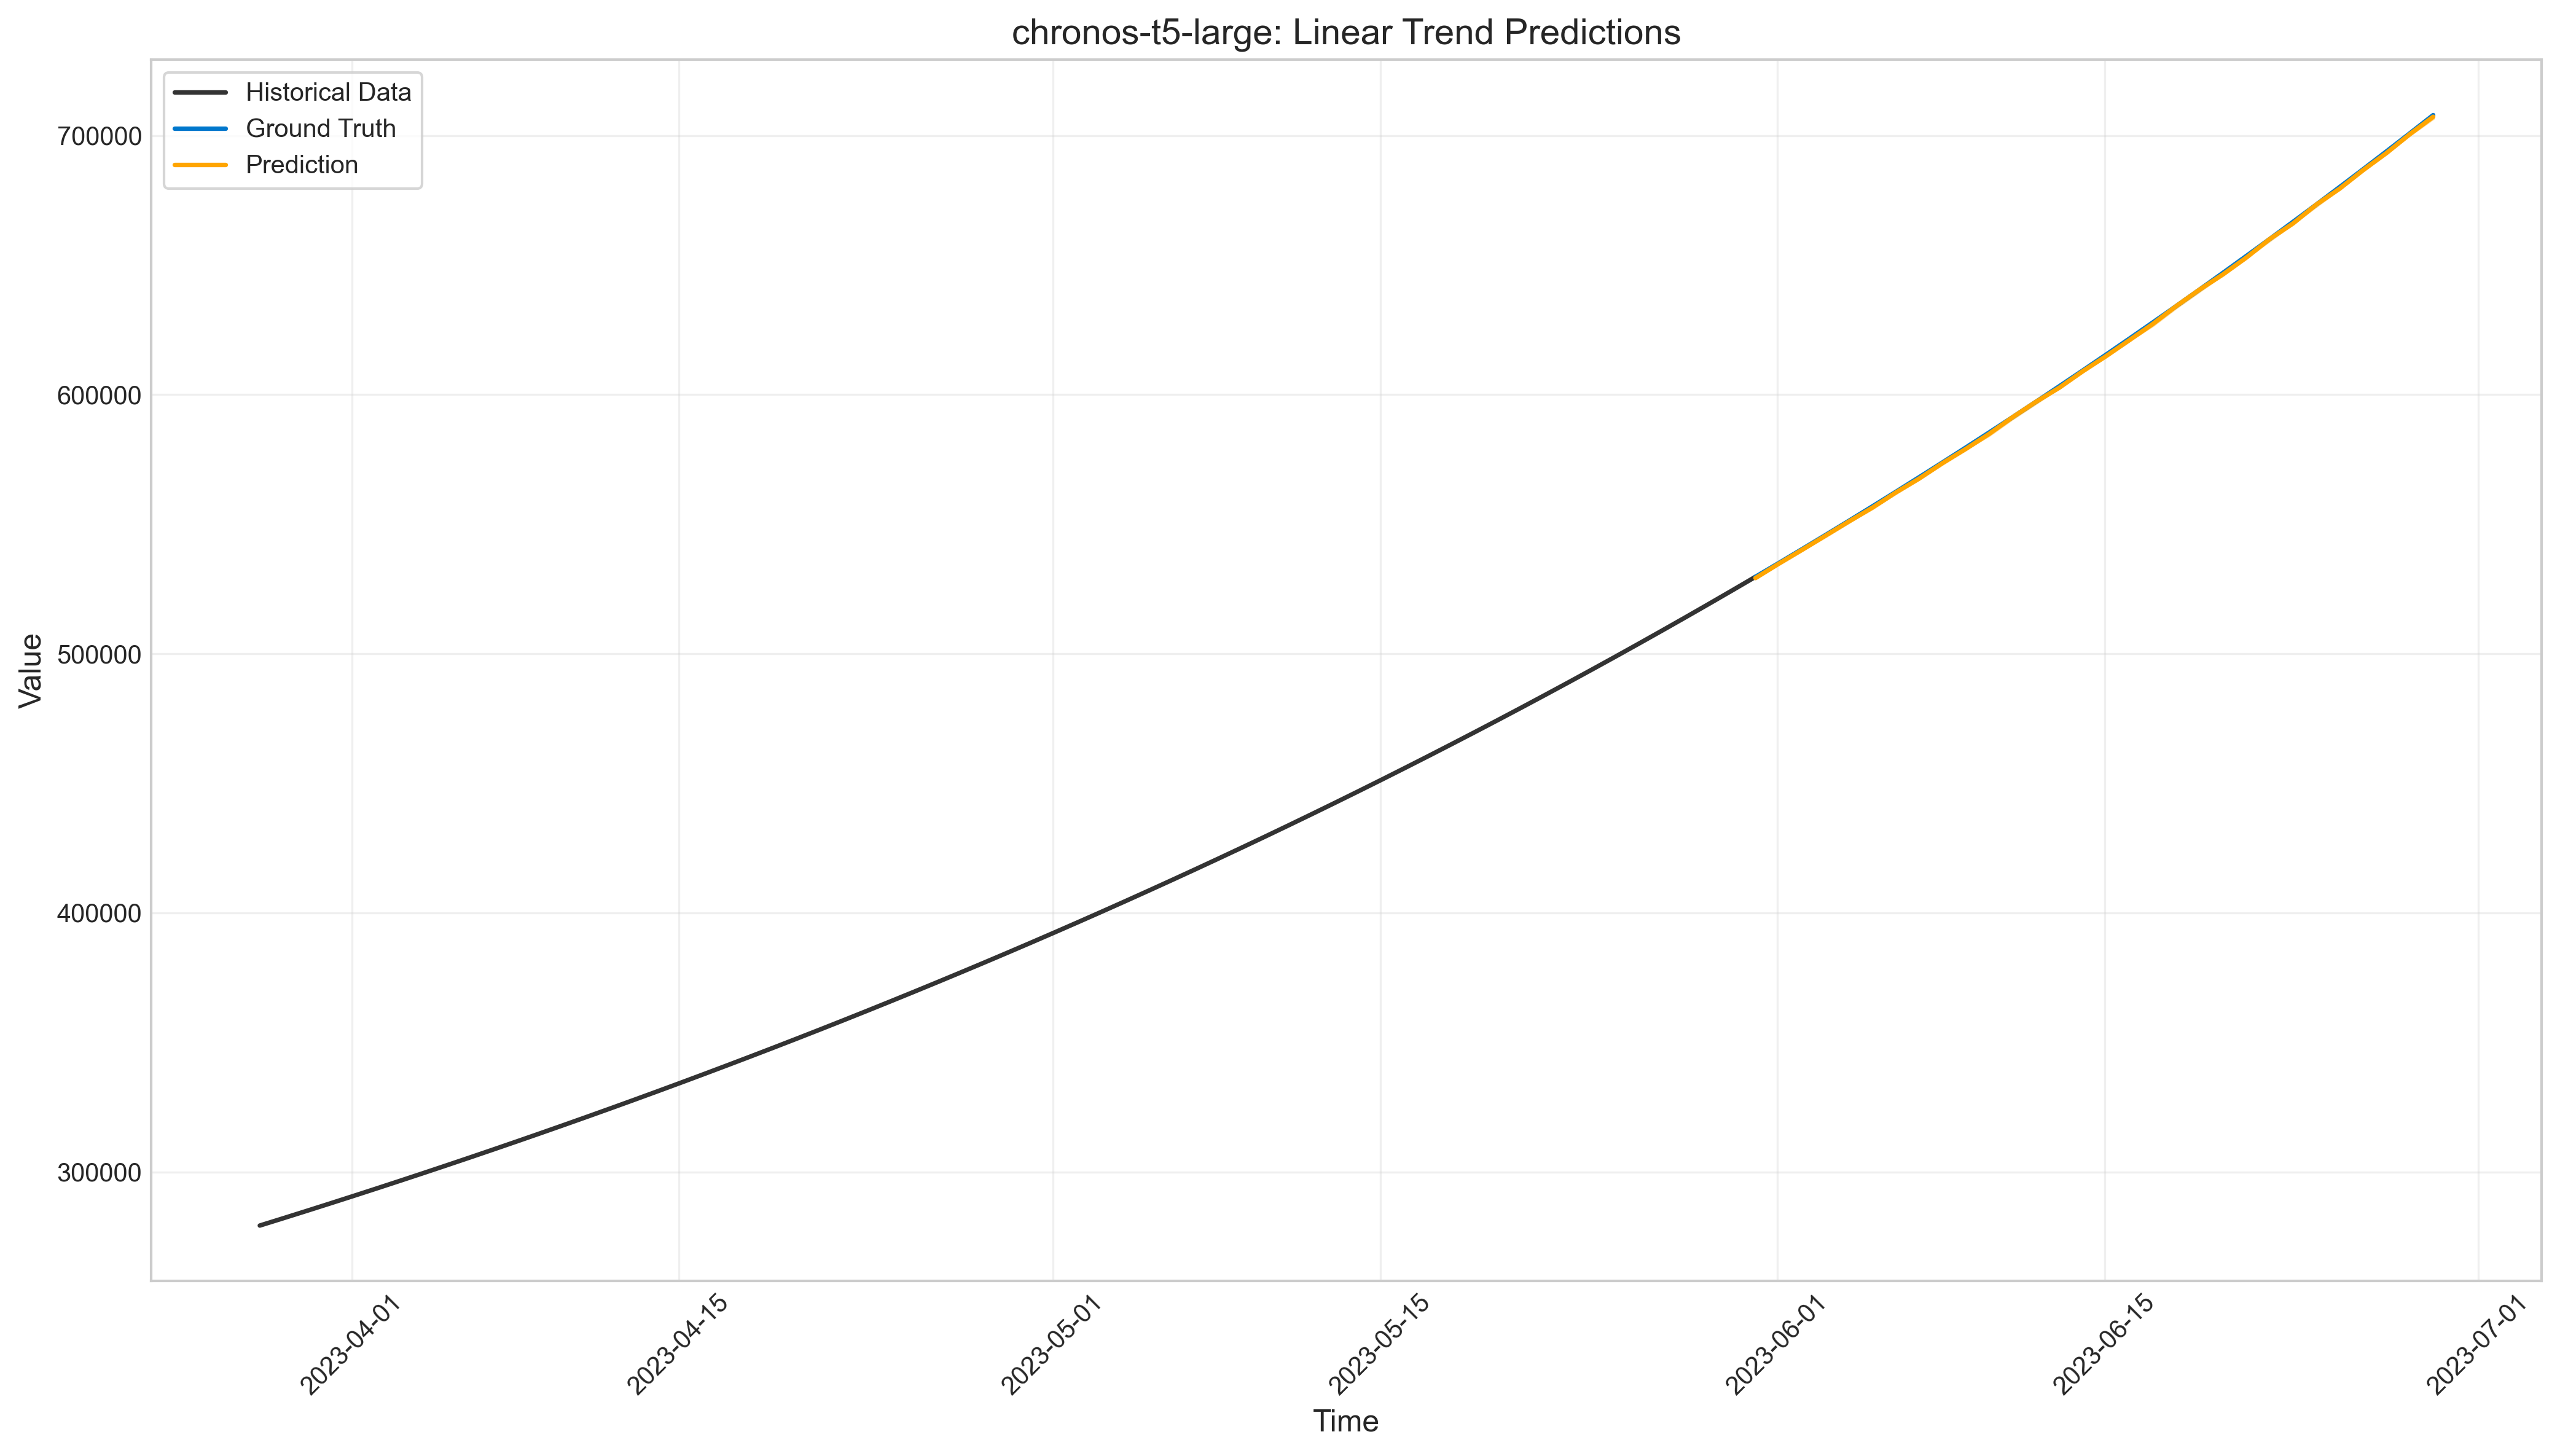

In [23]:
from data.synthetic.nonstationary import TrendGenerator

expo_trend_gen = TrendGenerator(
    seq_length=2000,
    num_samples=1,
    trend_type="exponential",
    seasonal_amplitude=1.0,
    trend_coefficient=0.01,
    seed=42,
)
expo_trend_data = expo_trend_gen.generate()

expo_trend_df = convert_synthetic_to_dataframe(expo_trend_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_expotrendf = expo_trend_df[expo_trend_df['Date'] <= test_date].index
test_start = date_indices_expotrendf[-1]

# Run Chronos comparison
expotrend_df_chronos_avg, expotrend_df_chronos_std, expotrend_df_chronos_preds = run_multiple_trials_comparison(
    expo_trend_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=70,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in expotrend_df_chronos_avg:
    print(f"{metric}: {expotrend_df_chronos_avg[metric]:.4f} ± {expotrend_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(expo_trend_df, test_start, expotrend_df_chronos_preds, "chronos-t5-large: Linear Trend Predictions", historical_window=64, FORECAST_STEPS=30)

## 5. Changing Patterns


Trial 1/5
Context scaling metrics: {'MAE': 0.20940883987013226, 'MSE': 0.09540363726777895, 'RMSE': 0.30887479221810726, 'Z-NormalizedMAE': 0.2853758495273889, 'Z-NormalizedMSE': 0.1771778166478777, 'Z-NormalizedRMSE': 0.4209249537006302, 'MAPE': 493.07627122595886, 'SMAPE': 52.86704090973217, 'MASE': 0.6290451280263903, 'DirectionalAccuracy': 73.33333333333333}

Trial 2/5
Context scaling metrics: {'MAE': 0.2103282808809089, 'MSE': 0.0928684093708621, 'RMSE': 0.30474318593015676, 'Z-NormalizedMAE': 0.2866288351210412, 'Z-NormalizedMSE': 0.17246954601643688, 'Z-NormalizedRMSE': 0.41529452923971544, 'MAPE': 469.77493035746767, 'SMAPE': 50.48519042336994, 'MASE': 0.631807045282106, 'DirectionalAccuracy': 76.66666666666667}

Trial 3/5
Context scaling metrics: {'MAE': 0.21440904594543053, 'MSE': 0.09683389990674221, 'RMSE': 0.3111814581666816, 'Z-NormalizedMAE': 0.29218997474500247, 'Z-NormalizedMSE': 0.17983401319197034, 'Z-NormalizedRMSE': 0.42406840626480335, 'MAPE': 501.54112279479284,

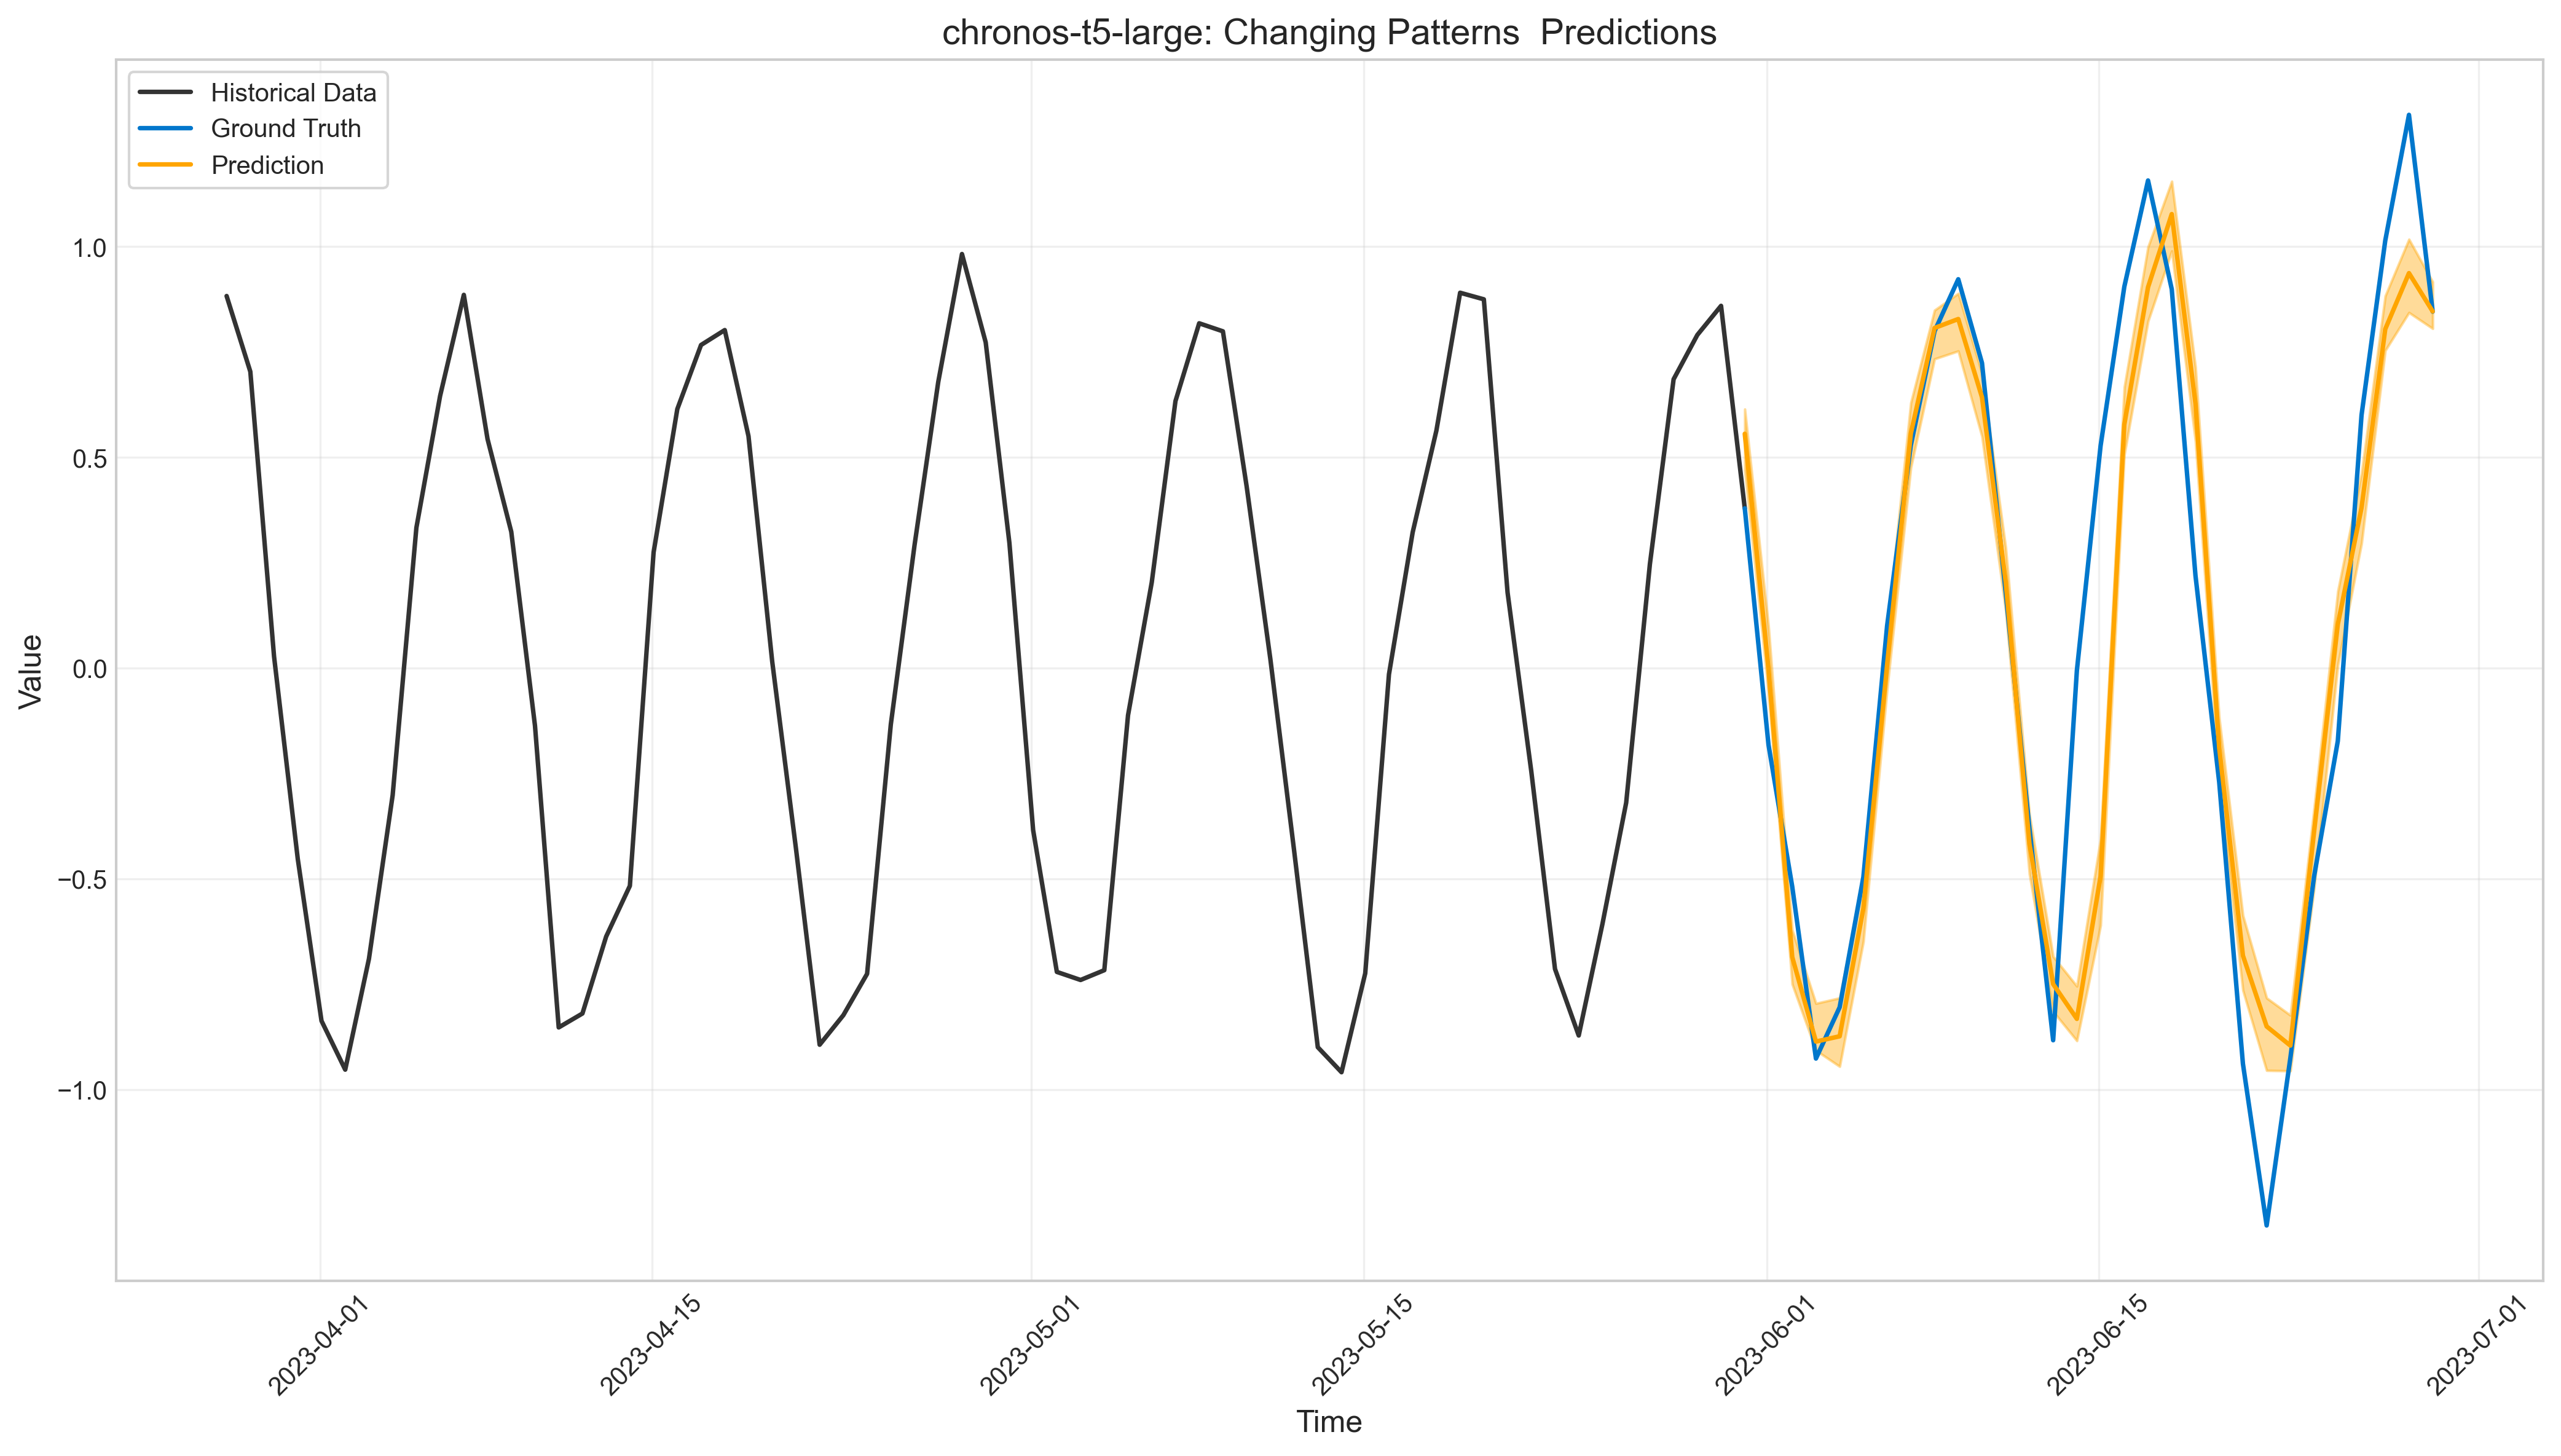

In [33]:
from data.synthetic.nonstationary import ChangingPatternGenerator

cp_gen = ChangingPatternGenerator(
    seq_length=2000,
    num_samples=1,
    change_points=2,
    seed=42,
)
cp_data = cp_gen.generate()

cp_df = convert_synthetic_to_dataframe(cp_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_cpdf = cp_df[cp_df['Date'] <= test_date].index
test_start = date_indices_cpdf[-1]

# Run Chronos comparison
cp_df_chronos_avg, cp_df_chronos_std, cp_df_chronos_preds = run_multiple_trials_comparison(
    cp_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in cp_df_chronos_avg:
    print(f"{metric}: {cp_df_chronos_avg[metric]:.4f} ± {cp_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(cp_df, test_start, cp_df_chronos_preds, "chronos-t5-large: Changing Patterns  Predictions", historical_window=64, FORECAST_STEPS=30)

## 6. Non-stationary

In [10]:
from data.synthetic.nonstationary import ARNonstationaryGenerator

# Instantiate the generator
generator_foo = ARNonstationaryGenerator(seq_length=1500, num_samples=1, seed=42)

# Generate the data
non_stationary = generator_foo.generate()
non_stationary_df = convert_synthetic_to_dataframe(non_stationary)

# Use the downloaded S&P 500 daily data as an example
non_stationary_data = non_stationary_df

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices = non_stationary_data[non_stationary_data['Date'] <= test_date].index
test_start = date_indices[-1]

# Run Chronos comparison
chronos_context_avg, chronos_context_std, chronos_context_preds = run_multiple_trials_comparison(
    non_stationary_data, 
    n_trials=5, 
    test_start=test_start
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in chronos_context_avg:
    print(f"{metric}: {chronos_context_avg[metric]:.4f} ± {chronos_context_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(non_stationary_data, test_start, chronos_context_preds, "Chronos-large Simple Sine Wave Predictions", 64, FORECAST_STEPS)

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

# Noise


## 7. Gaussian Noise


Trial 1/5
Context scaling metrics: {'MAE': 0.7032053724733291, 'MSE': 0.9013994699478967, 'RMSE': 0.9494205969684335, 'Z-NormalizedMAE': 0.7475883902175461, 'Z-NormalizedMSE': 1.0187744268893224, 'Z-NormalizedRMSE': 1.0093435623658193, 'MAPE': 193.31412968007305, 'SMAPE': 155.98885227817755, 'MASE': 0.6285492967434949, 'DirectionalAccuracy': 56.666666666666664}

Trial 2/5
Context scaling metrics: {'MAE': 0.7049304314552071, 'MSE': 0.8976122375621443, 'RMSE': 0.9474240009426319, 'Z-NormalizedMAE': 0.7494223268138445, 'Z-NormalizedMSE': 1.0144940432947829, 'Z-NormalizedRMSE': 1.007220950583725, 'MAPE': 212.23368797833174, 'SMAPE': 159.48989153880711, 'MASE': 0.6300912141581568, 'DirectionalAccuracy': 46.666666666666664}

Trial 3/5
Context scaling metrics: {'MAE': 0.7088187765924456, 'MSE': 0.8934372172106854, 'RMSE': 0.945218079181035, 'Z-NormalizedMAE': 0.7535560860192587, 'Z-NormalizedMSE': 1.0097753762580088, 'Z-NormalizedRMSE': 1.0048758014093129, 'MAPE': 255.52098025329494, 'SMAPE'

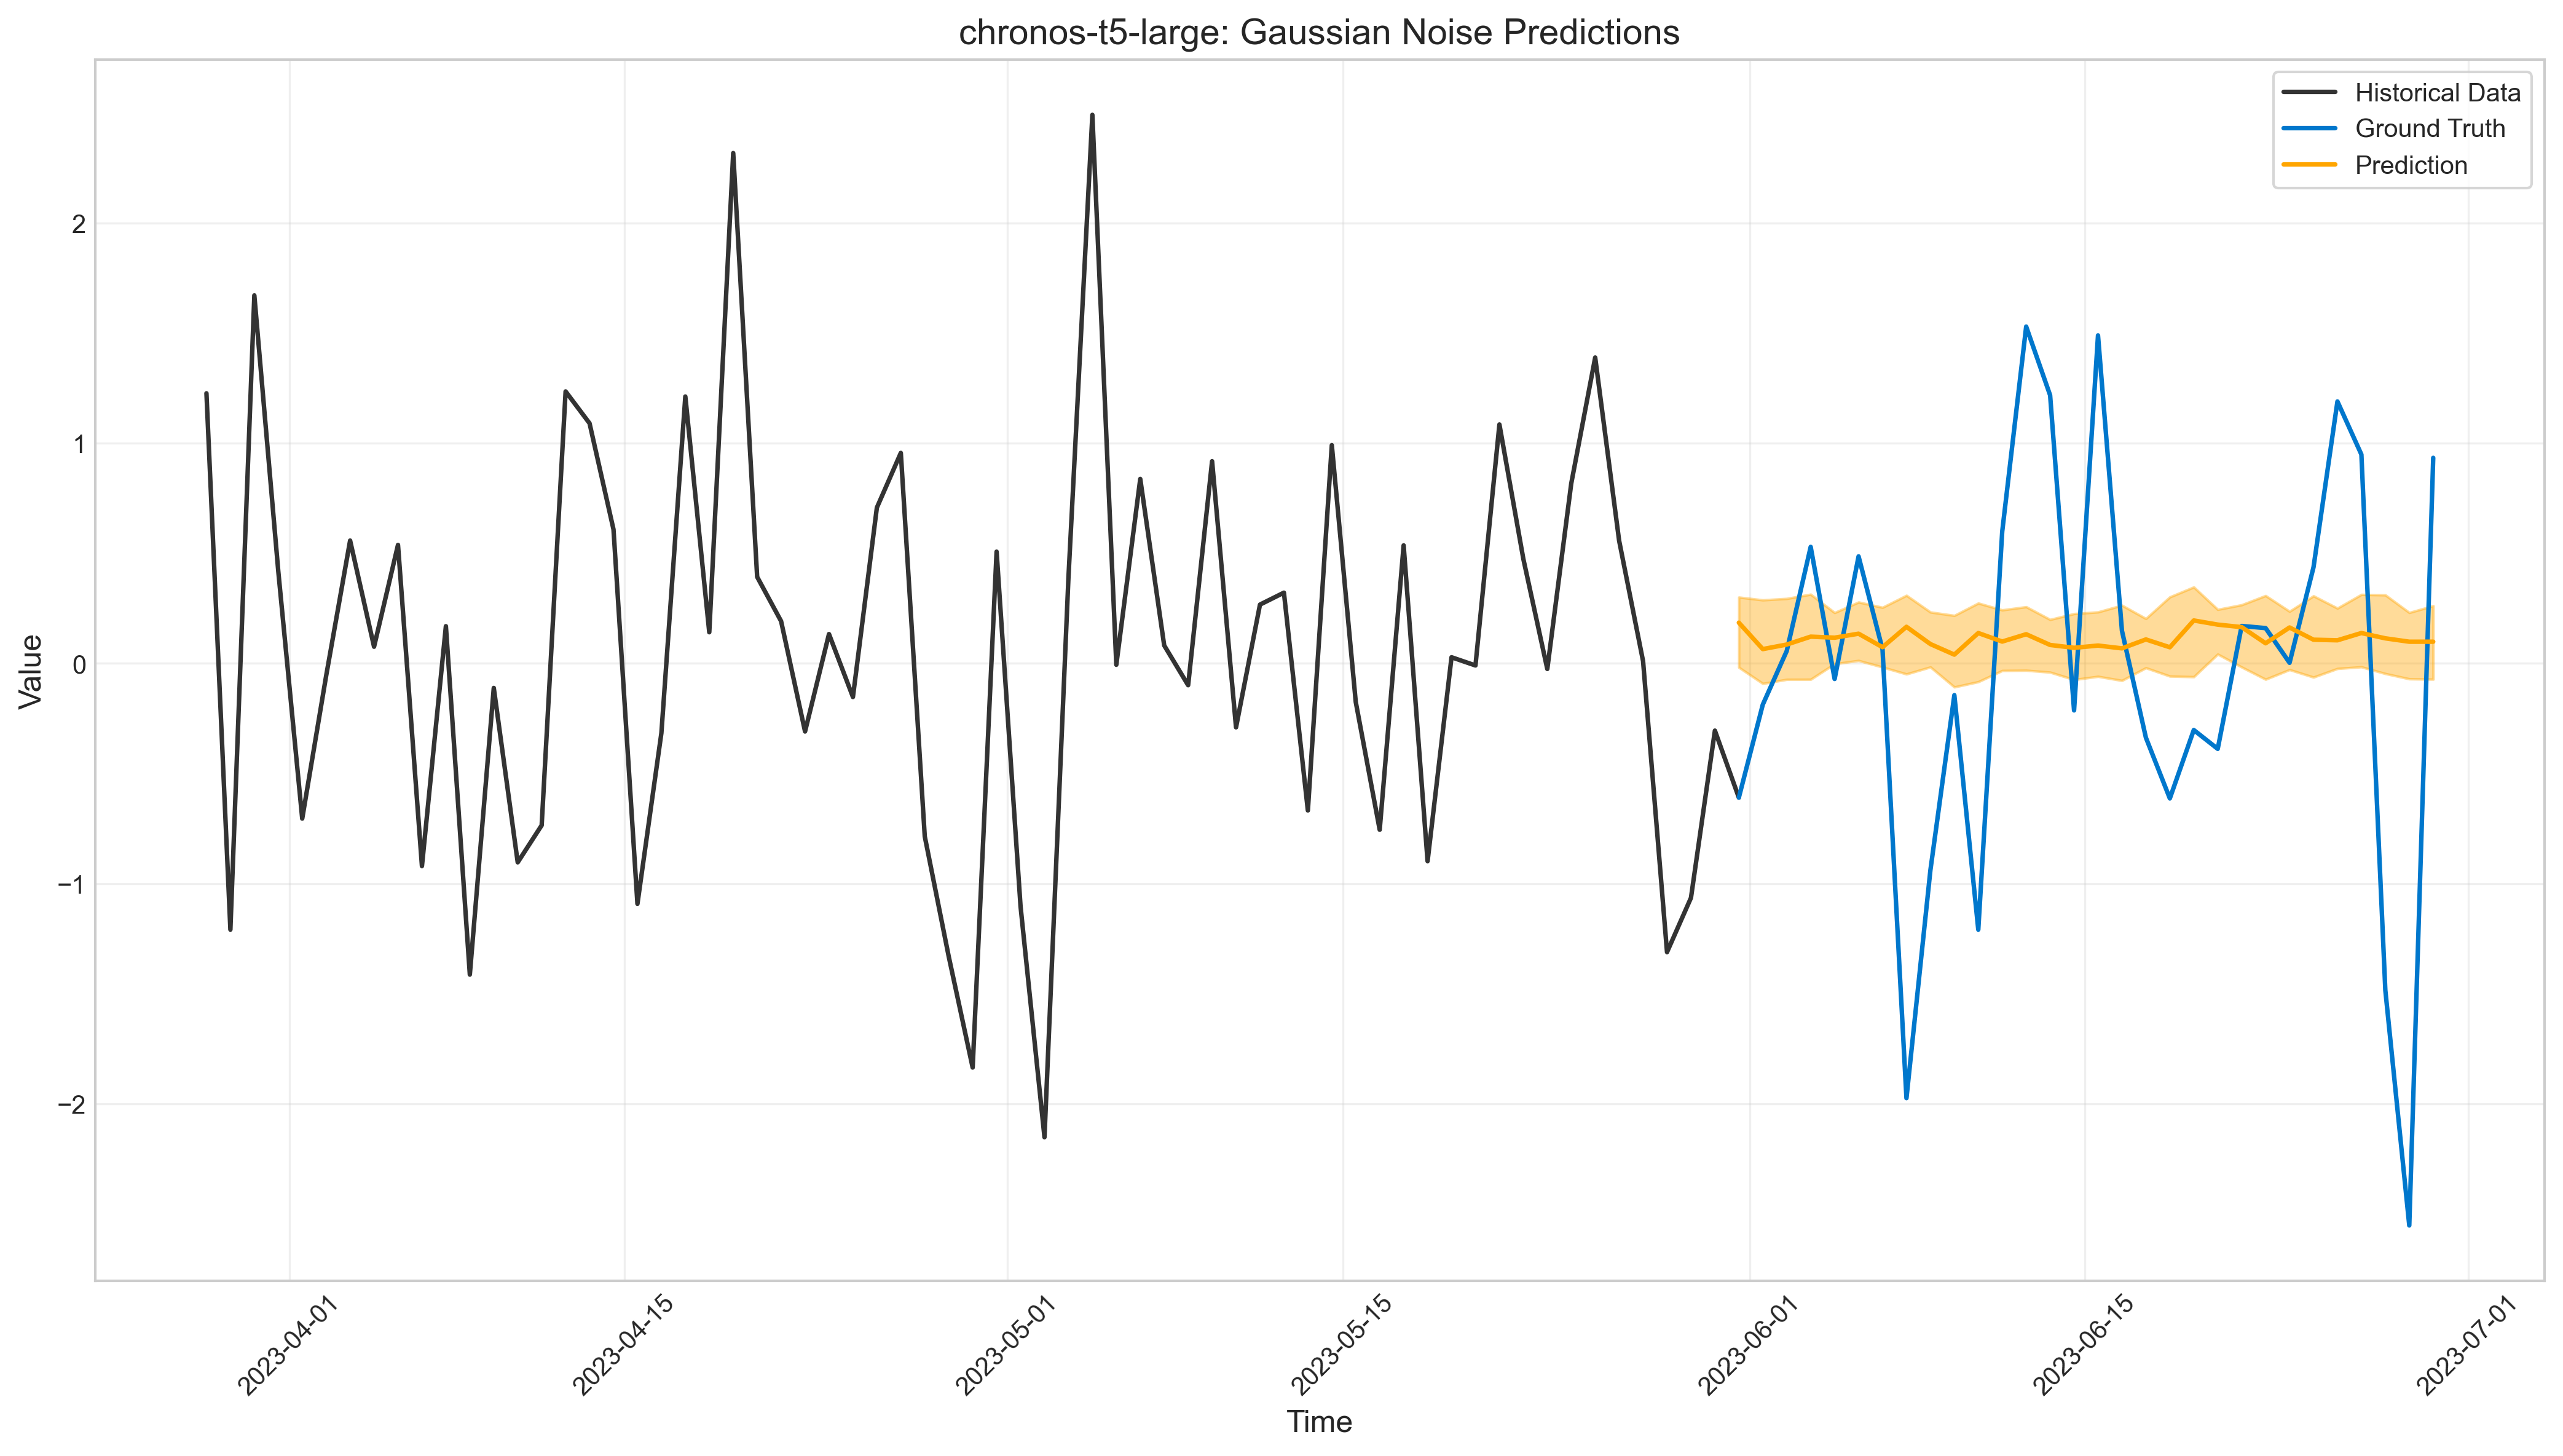

In [9]:
from data.synthetic.noise import NoiseGenerator

gaussian_gen = NoiseGenerator(
    seq_length=2000,
    num_samples=1,
    noise_type="gaussian",
    noise_params={
        "mean": 0.0,
        "std": 1.0,
    },
    seed=42,
)
gaussian_data = gaussian_gen.generate()

gaussian_df = convert_synthetic_to_dataframe(gaussian_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_gaussiandf = gaussian_df[gaussian_df['Date'] <= test_date].index
test_start = date_indices_gaussiandf[-1]

# Run Chronos comparison
gaussian_df_chronos_avg, gaussian_df_chronos_std, gaussian_df_chronos_preds = run_multiple_trials_comparison(
    gaussian_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=500,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in gaussian_df_chronos_avg:
    print(f"{metric}: {gaussian_df_chronos_avg[metric]:.4f} ± {gaussian_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(gaussian_df, test_start, gaussian_df_chronos_preds, "chronos-t5-large: Gaussian Noise Predictions", historical_window=64, FORECAST_STEPS=30)

## 8. Pink Noise


Trial 1/5
Context scaling metrics: {'MAE': 0.03716997771158757, 'MSE': 0.0026819672295384594, 'RMSE': 0.05178771311361856, 'Z-NormalizedMAE': 0.6621967910371914, 'Z-NormalizedMSE': 0.8512223328543777, 'Z-NormalizedRMSE': 0.9226171106447016, 'MAPE': 16519.5498440956, 'SMAPE': 92.10515973072614, 'MASE': 0.8628317551120734, 'DirectionalAccuracy': 43.333333333333336}

Trial 2/5
Context scaling metrics: {'MAE': 0.03607668546350676, 'MSE': 0.0025566388336363518, 'RMSE': 0.05056321621135618, 'Z-NormalizedMAE': 0.6427193884957512, 'Z-NormalizedMSE': 0.8114446918907898, 'Z-NormalizedRMSE': 0.9008022490484745, 'MAPE': 16390.29908116778, 'SMAPE': 88.30434951030584, 'MASE': 0.8374530132526745, 'DirectionalAccuracy': 46.666666666666664}

Trial 3/5
Context scaling metrics: {'MAE': 0.036668088424748536, 'MSE': 0.002628631012609046, 'RMSE': 0.05127017663914418, 'Z-NormalizedMAE': 0.6532554492430276, 'Z-NormalizedMSE': 0.8342940950667386, 'Z-NormalizedRMSE': 0.9133970084616758, 'MAPE': 16642.917086216

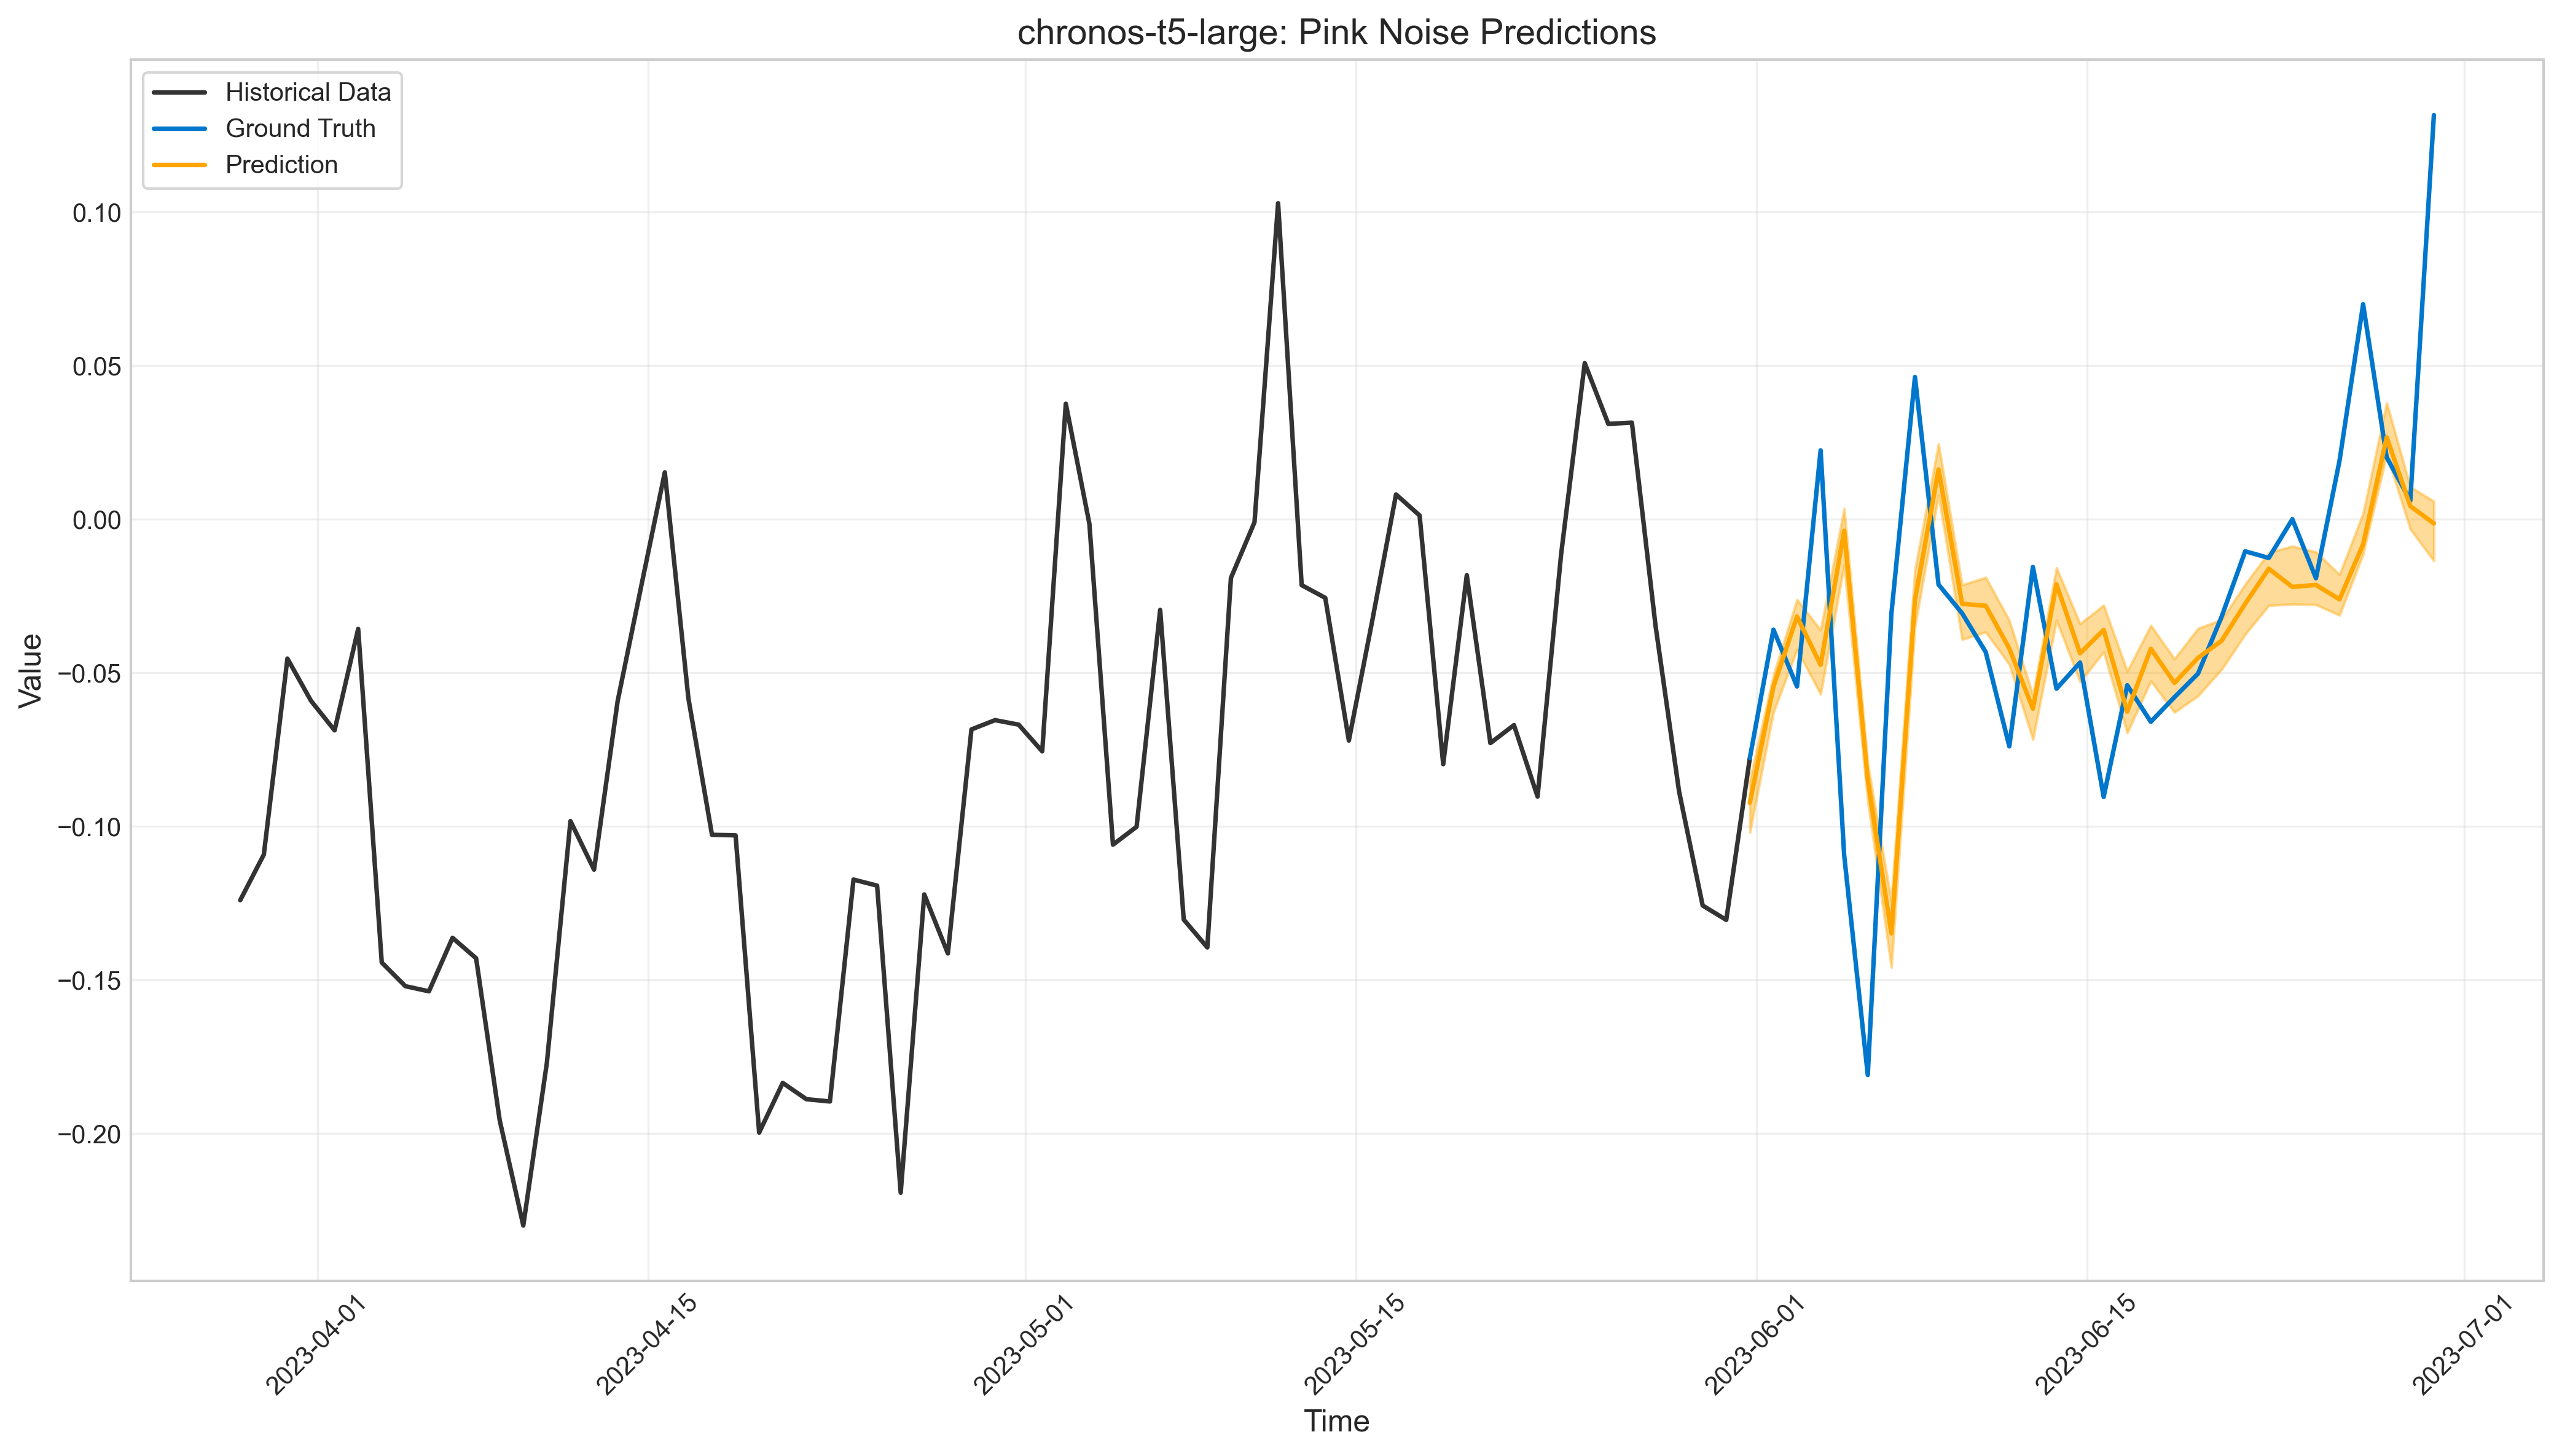

In [25]:
from data.synthetic.noise import NoiseGenerator

pink_gen = NoiseGenerator(
    seq_length=2000,
    num_samples=1,
    noise_type="pink",
    seed=42,
)
pink_data = pink_gen.generate()

pink_df = convert_synthetic_to_dataframe(pink_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_pinkdf = pink_df[pink_df['Date'] <= test_date].index
test_start = date_indices_pinkdf[-1]

# Run Chronos comparison
pink_df_chronos_avg, pink_df_chronos_std, pink_df_chronos_preds = run_multiple_trials_comparison(
    pink_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=500,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in pink_df_chronos_avg:
    print(f"{metric}: {pink_df_chronos_avg[metric]:.4f} ± {pink_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(pink_df, test_start, pink_df_chronos_preds, "chronos-t5-large: Pink Noise Predictions", historical_window=64, FORECAST_STEPS=30)

## 9. Brownian Noise


Trial 1/5
Context scaling metrics: {'MAE': 0.06465349108416302, 'MSE': 0.007476681646018454, 'RMSE': 0.08646780699207338, 'Z-NormalizedMAE': 0.49540410415907693, 'Z-NormalizedMSE': 0.43897938783178214, 'Z-NormalizedRMSE': 0.6625551960642843, 'MAPE': 1.2836480969046176, 'SMAPE': 1.283470833950879, 'MASE': 0.852977244632005, 'DirectionalAccuracy': 58.620689655172406}

Trial 2/5
Context scaling metrics: {'MAE': 0.06532503572689713, 'MSE': 0.007811596763072062, 'RMSE': 0.08838323802097353, 'Z-NormalizedMAE': 0.5005497810058762, 'Z-NormalizedMSE': 0.4586433029241273, 'Z-NormalizedRMSE': 0.6772320894081492, 'MAPE': 1.296807492526634, 'SMAPE': 1.297400228991477, 'MASE': 0.8618369719166626, 'DirectionalAccuracy': 65.51724137931035}

Trial 3/5
Context scaling metrics: {'MAE': 0.06529286130122083, 'MSE': 0.007671407518179919, 'RMSE': 0.08758657156311074, 'Z-NormalizedMAE': 0.5003032460970613, 'Z-NormalizedMSE': 0.4504123534445377, 'Z-NormalizedRMSE': 0.6711276729837161, 'MAPE': 1.29474540035072

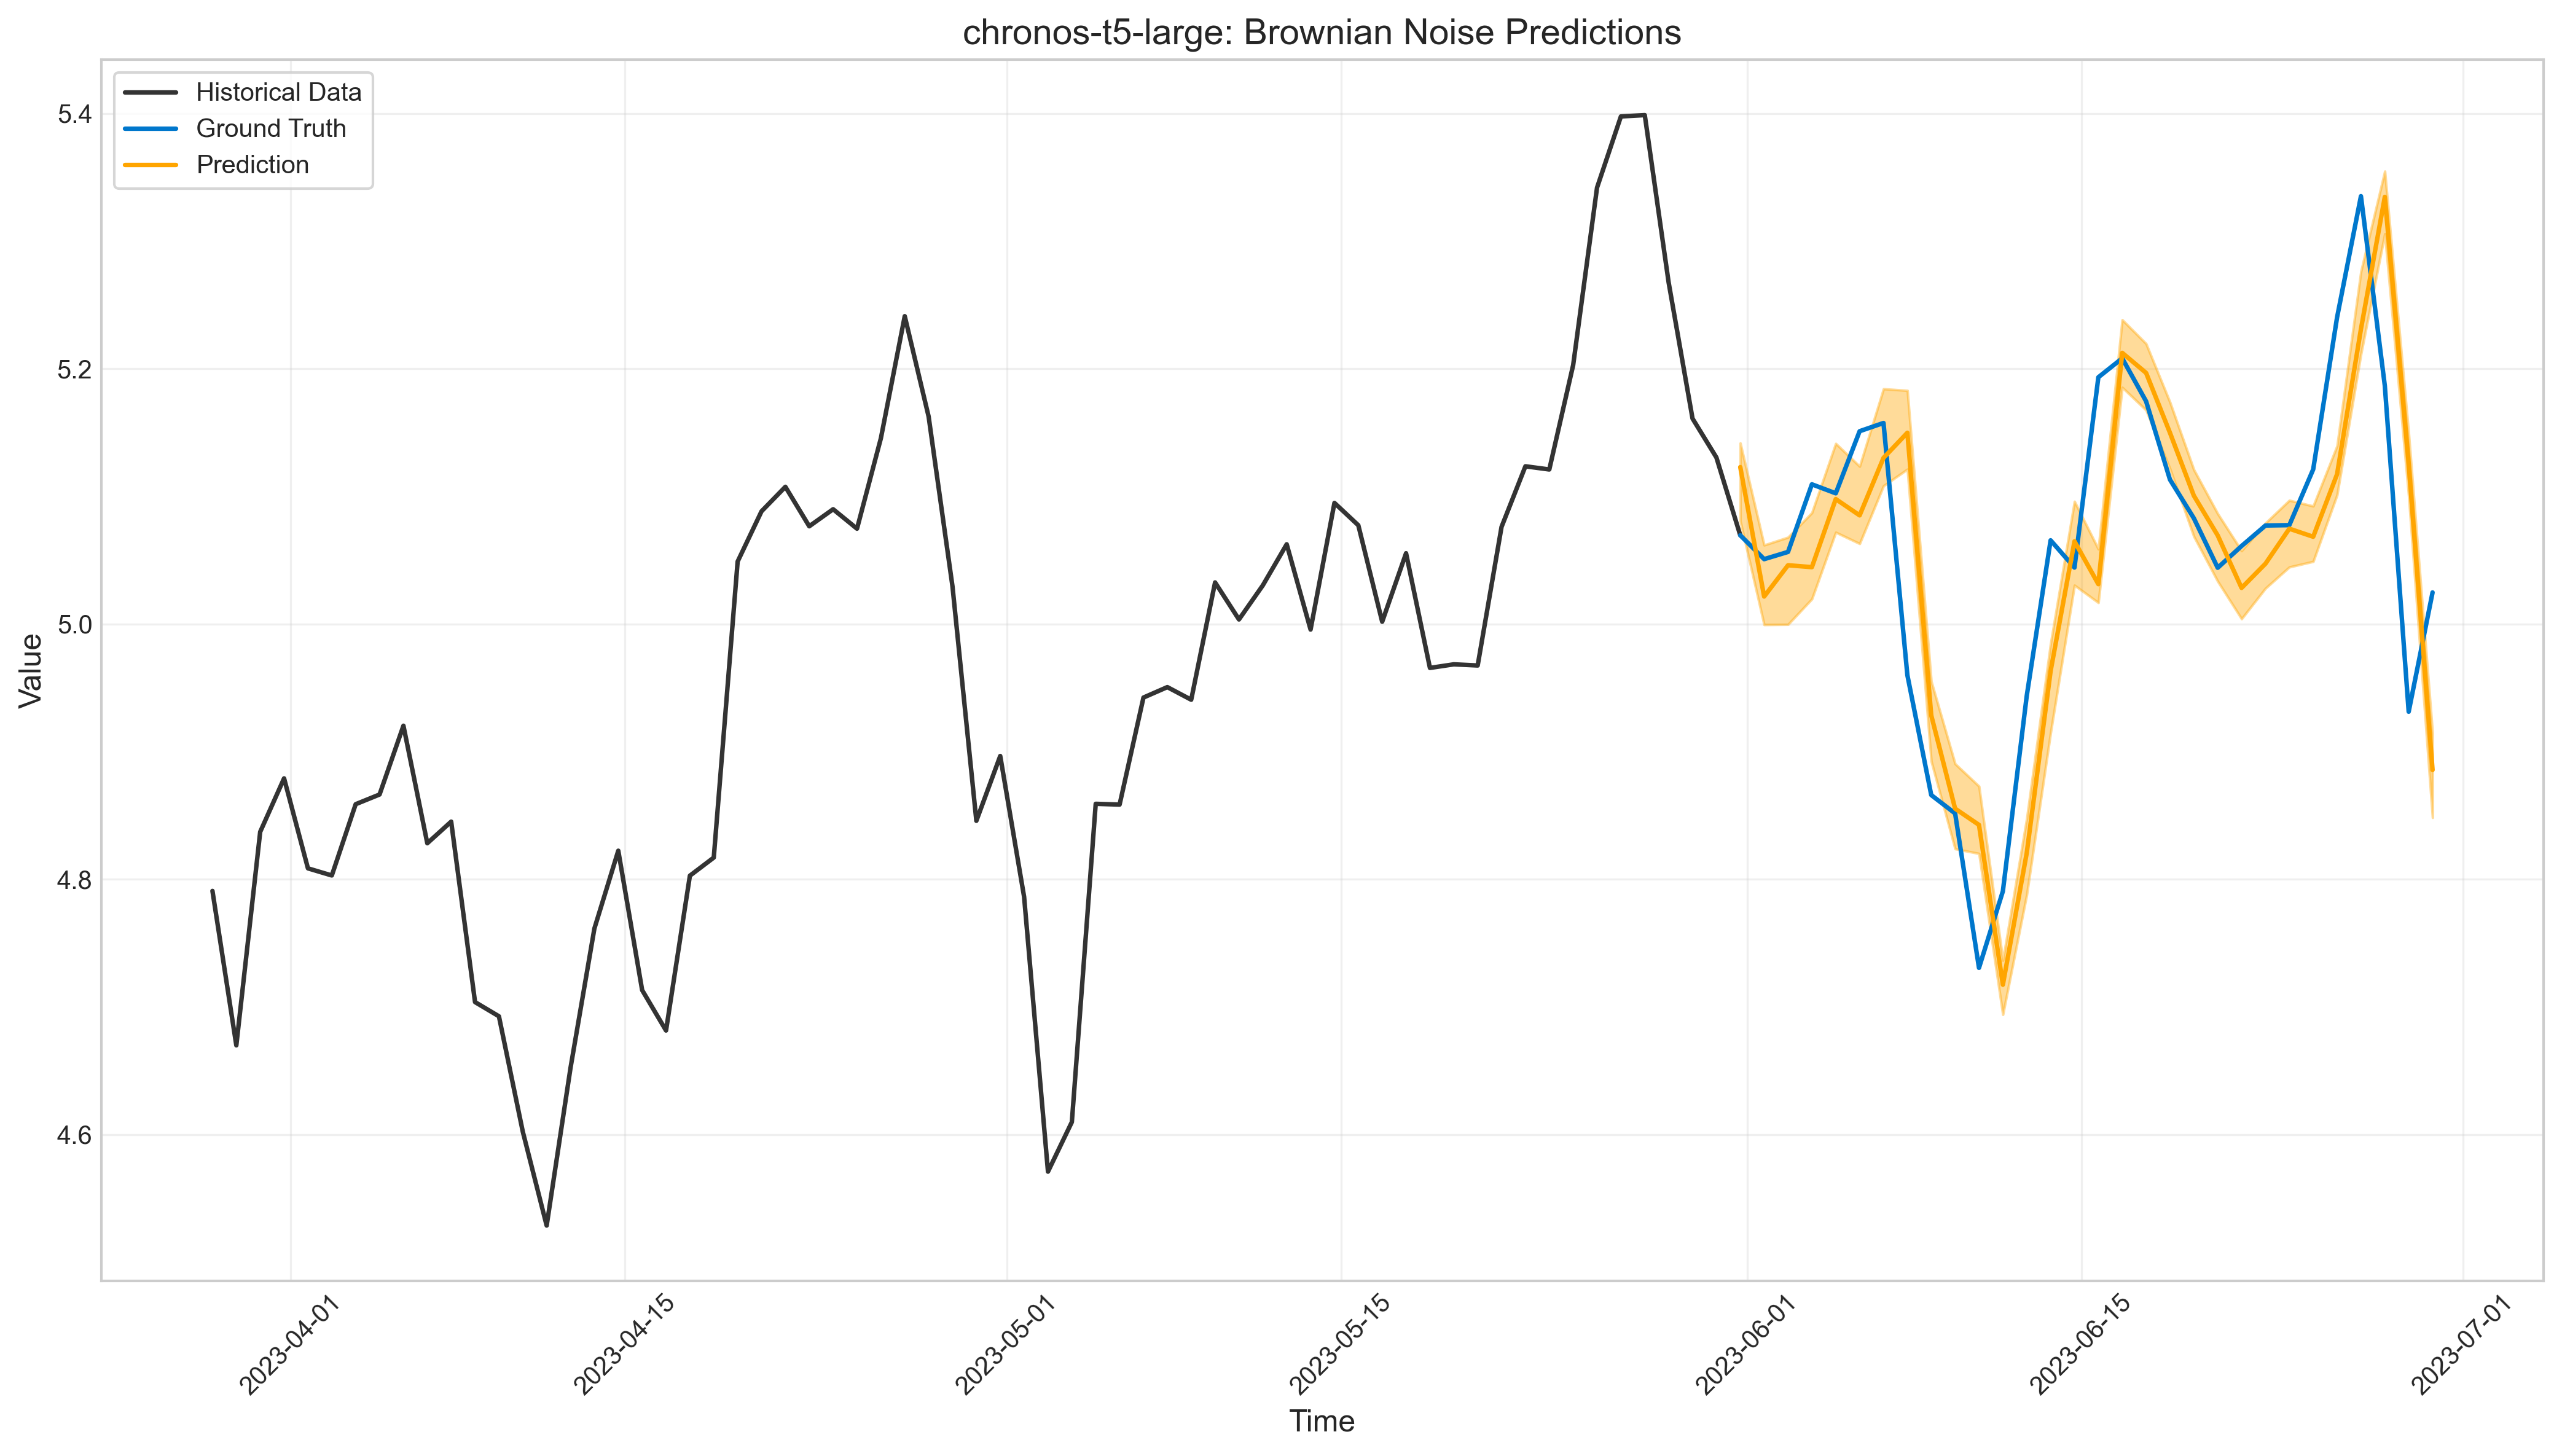

In [27]:
from data.synthetic.noise import NoiseGenerator

brownian_gen = NoiseGenerator(
    seq_length=2000,
    num_samples=1,
    noise_type="brownian",
    seed=42,
)
brownian_data = brownian_gen.generate()

brownian_df = convert_synthetic_to_dataframe(brownian_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_browniandf = brownian_df[brownian_df['Date'] <= test_date].index
test_start = date_indices_browniandf[-1]

# Run Chronos comparison
brownian_df_chronos_avg, brownian_df_chronos_std, brownian_df_chronos_preds = run_multiple_trials_comparison(
    brownian_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in brownian_df_chronos_avg:
    print(f"{metric}: {brownian_df_chronos_avg[metric]:.4f} ± {brownian_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(brownian_df, test_start, brownian_df_chronos_preds, "chronos-t5-large: Brownian Noise Predictions", historical_window=64, FORECAST_STEPS=30)

## 10. Heavy-tailed Noise


Trial 1/5
Context scaling metrics: {'MAE': 1.1867837298059825, 'MSE': 2.4037074225957746, 'RMSE': 1.5503894422356514, 'Z-NormalizedMAE': 0.8532196163559869, 'Z-NormalizedMSE': 1.2423961605390976, 'Z-NormalizedRMSE': 1.1146282611431928, 'MAPE': 107.26270499158939, 'SMAPE': 174.72508727717135, 'MASE': 0.6216406128119443, 'DirectionalAccuracy': 46.666666666666664}

Trial 2/5
Context scaling metrics: {'MAE': 1.1797383870248874, 'MSE': 2.3690981717153354, 'RMSE': 1.539187503754931, 'Z-NormalizedMAE': 0.848154477262982, 'Z-NormalizedMSE': 1.224507793590279, 'Z-NormalizedRMSE': 1.1065748025281794, 'MAPE': 125.26318449978866, 'SMAPE': 175.9713358875016, 'MASE': 0.6179502427016075, 'DirectionalAccuracy': 56.666666666666664}

Trial 3/5
Context scaling metrics: {'MAE': 1.1840090373160819, 'MSE': 2.3277452585551544, 'RMSE': 1.5256950083667293, 'Z-NormalizedMAE': 0.8512247945512375, 'Z-NormalizedMSE': 1.203133852629597, 'Z-NormalizedRMSE': 1.0968745838196803, 'MAPE': 116.31620655898647, 'SMAPE': 1

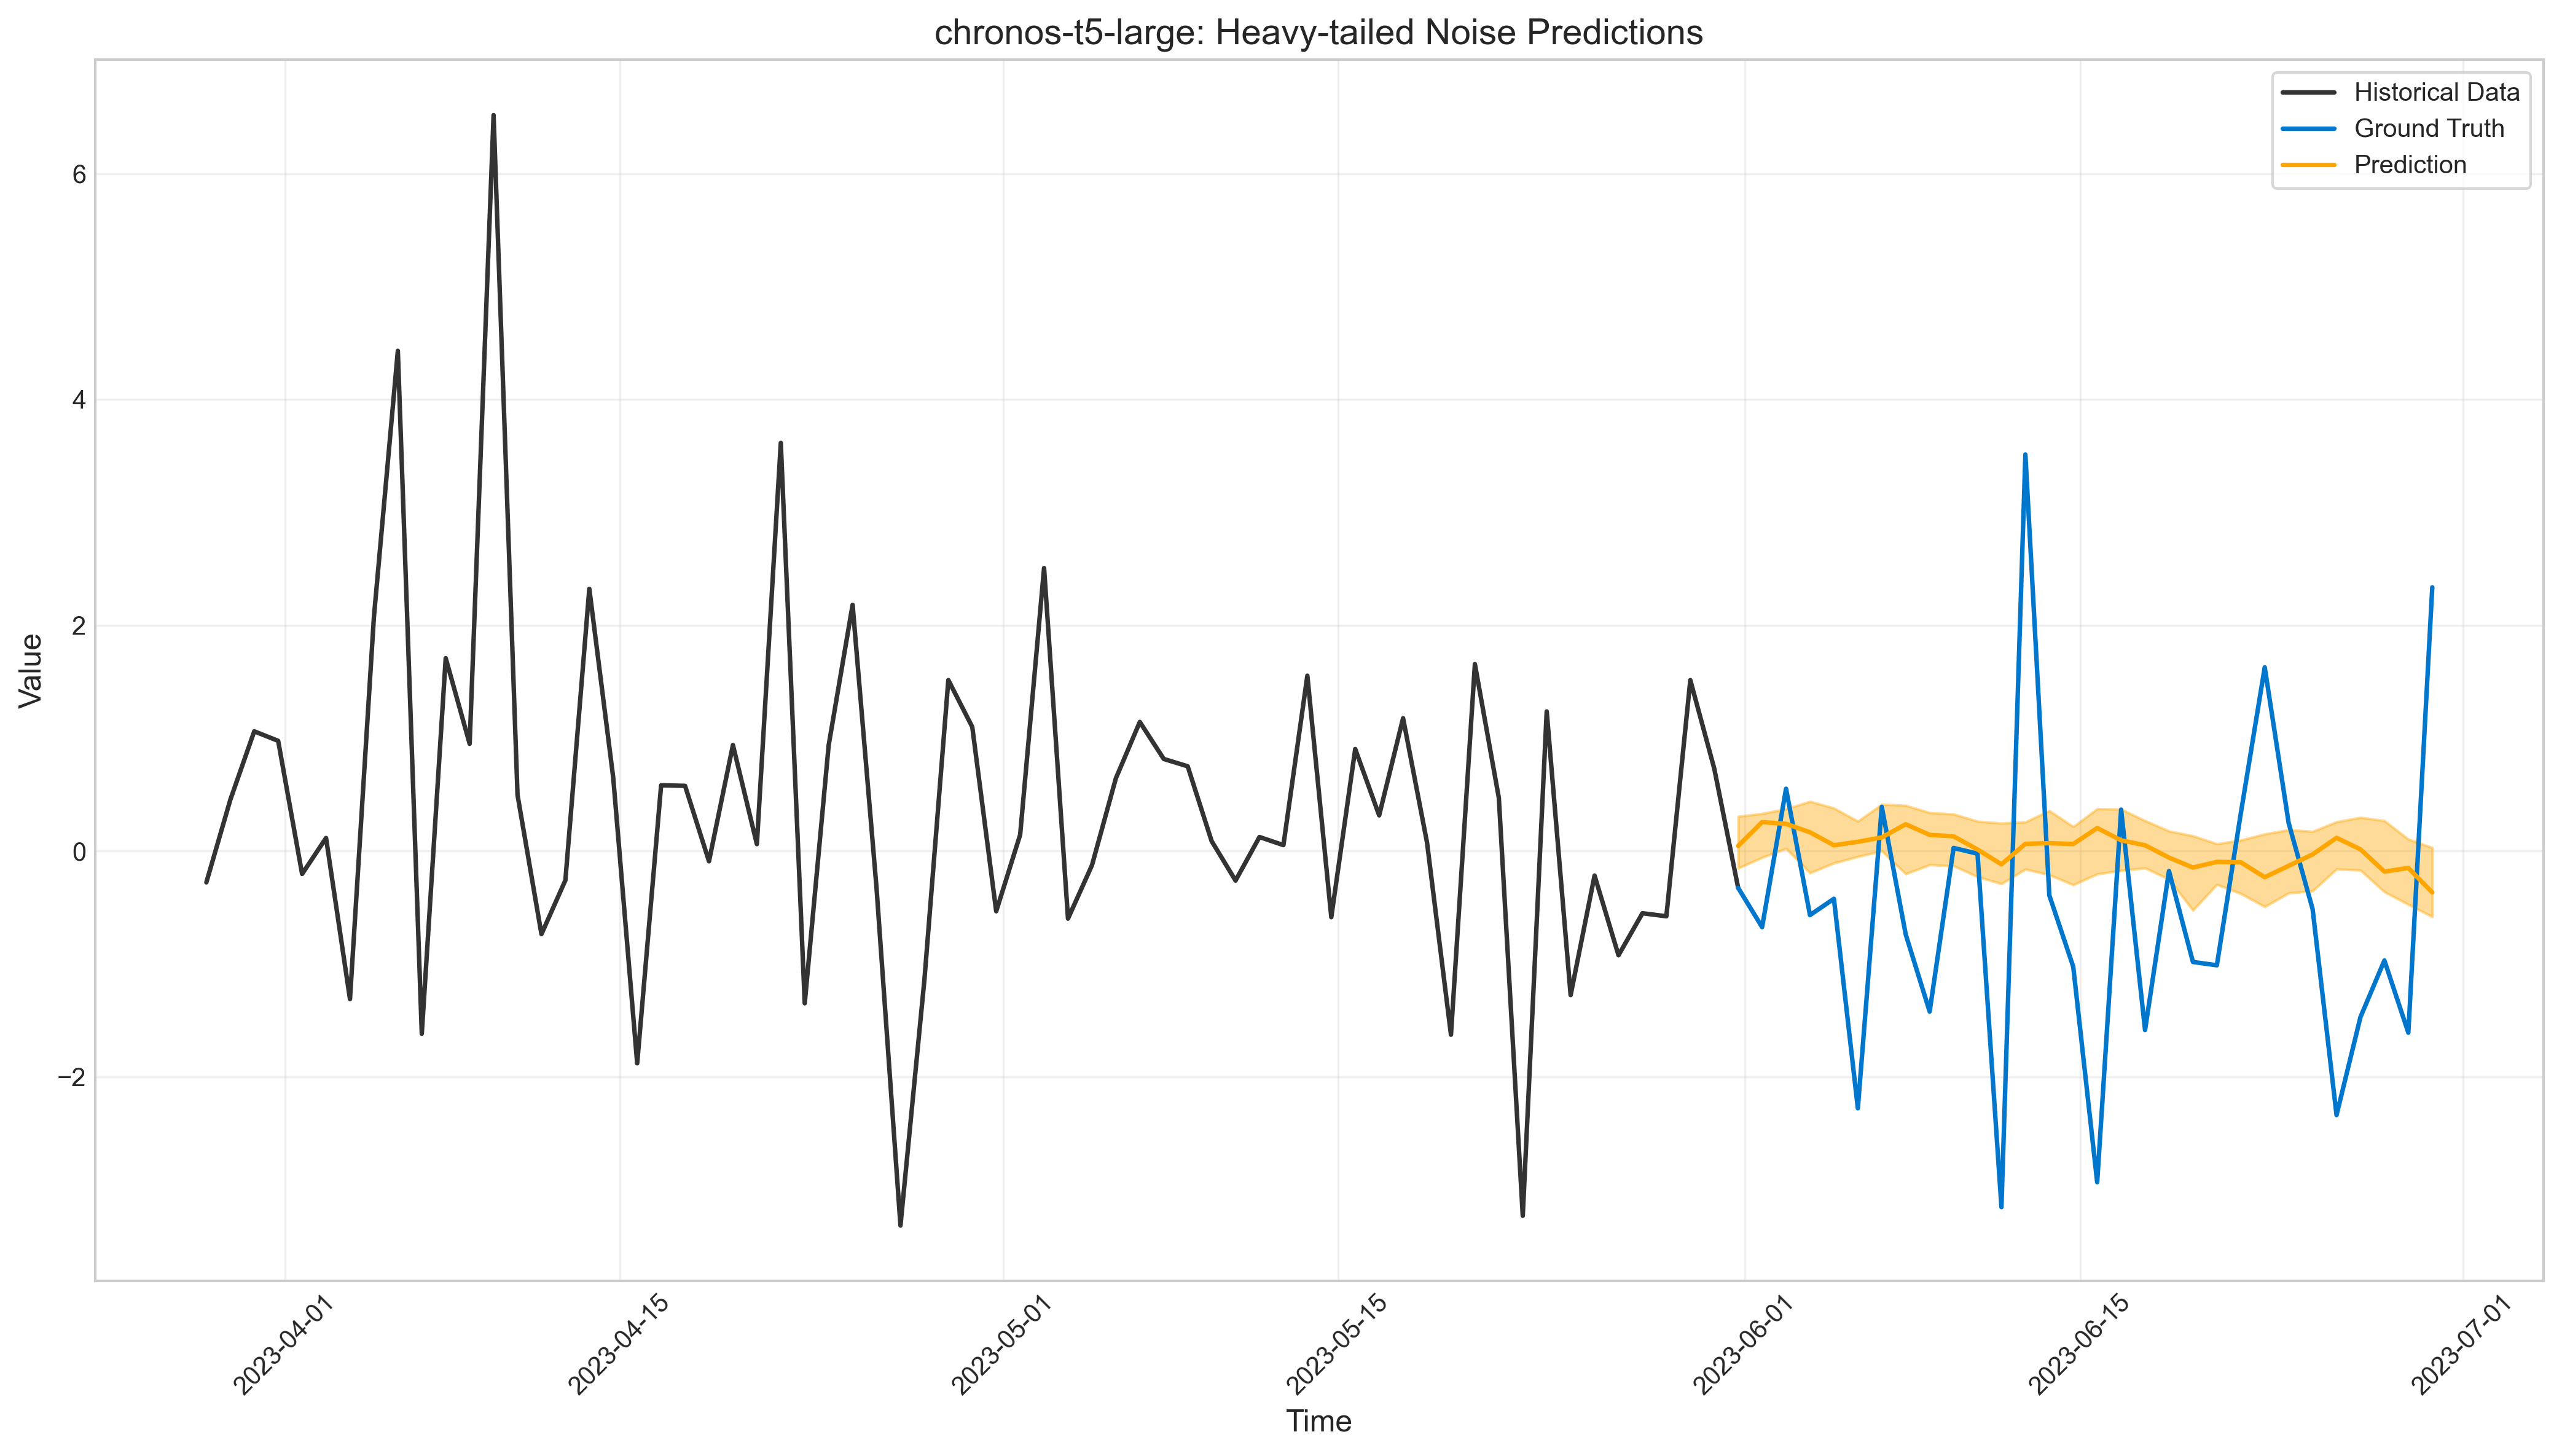

In [30]:
from data.synthetic.noise import NoiseGenerator

heavy_tailed_gen = NoiseGenerator(
    seq_length=2000,
    num_samples=1,
    noise_type="heavy_tailed",
    seed=42,
)
heavy_tailed_data = heavy_tailed_gen.generate()

heavy_tailed_df = convert_synthetic_to_dataframe(heavy_tailed_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_heavy_taileddf = heavy_tailed_df[heavy_tailed_df['Date'] <= test_date].index
test_start = date_indices_heavy_taileddf[-1]

# Run Chronos comparison
heavy_tailed_df_chronos_avg, heavy_tailed_df_chronos_std, heavy_tailed_df_chronos_preds = run_multiple_trials_comparison(
    heavy_tailed_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in heavy_tailed_df_chronos_avg:
    print(f"{metric}: {heavy_tailed_df_chronos_avg[metric]:.4f} ± {heavy_tailed_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(heavy_tailed_df, test_start, heavy_tailed_df_chronos_preds, "chronos-t5-large: Heavy-tailed Noise Predictions", historical_window=64, FORECAST_STEPS=30)

## 11. Mixed Noise (Gaussina + Pink + Brownian) on Sine-based Signal


Trial 1/5
Context scaling metrics: {'MAE': 0.16172748840355047, 'MSE': 0.03901563130677707, 'RMSE': 0.19752374871588751, 'Z-NormalizedMAE': 0.23550043871890788, 'Z-NormalizedMSE': 0.08272835627316305, 'Z-NormalizedRMSE': 0.28762537487704914, 'MAPE': 75.92681474536191, 'SMAPE': 36.486507956383605, 'MASE': 0.5735833563092484, 'DirectionalAccuracy': 76.66666666666667}

Trial 2/5
Context scaling metrics: {'MAE': 0.15569951037710403, 'MSE': 0.037991438132398275, 'RMSE': 0.1949139249320024, 'Z-NormalizedMAE': 0.22672276286535206, 'Z-NormalizedMSE': 0.0805566672607176, 'Z-NormalizedRMSE': 0.28382506453926437, 'MAPE': 70.20715100508978, 'SMAPE': 36.62150108638234, 'MASE': 0.5522045053649977, 'DirectionalAccuracy': 70.0}

Trial 3/5
Context scaling metrics: {'MAE': 0.15251620592073098, 'MSE': 0.037835992447349746, 'RMSE': 0.194514761515289, 'Z-NormalizedMAE': 0.22208737525467517, 'Z-NormalizedMSE': 0.08022706177739976, 'Z-NormalizedRMSE': 0.2832438203693062, 'MAPE': 64.24546373444507, 'SMAPE': 

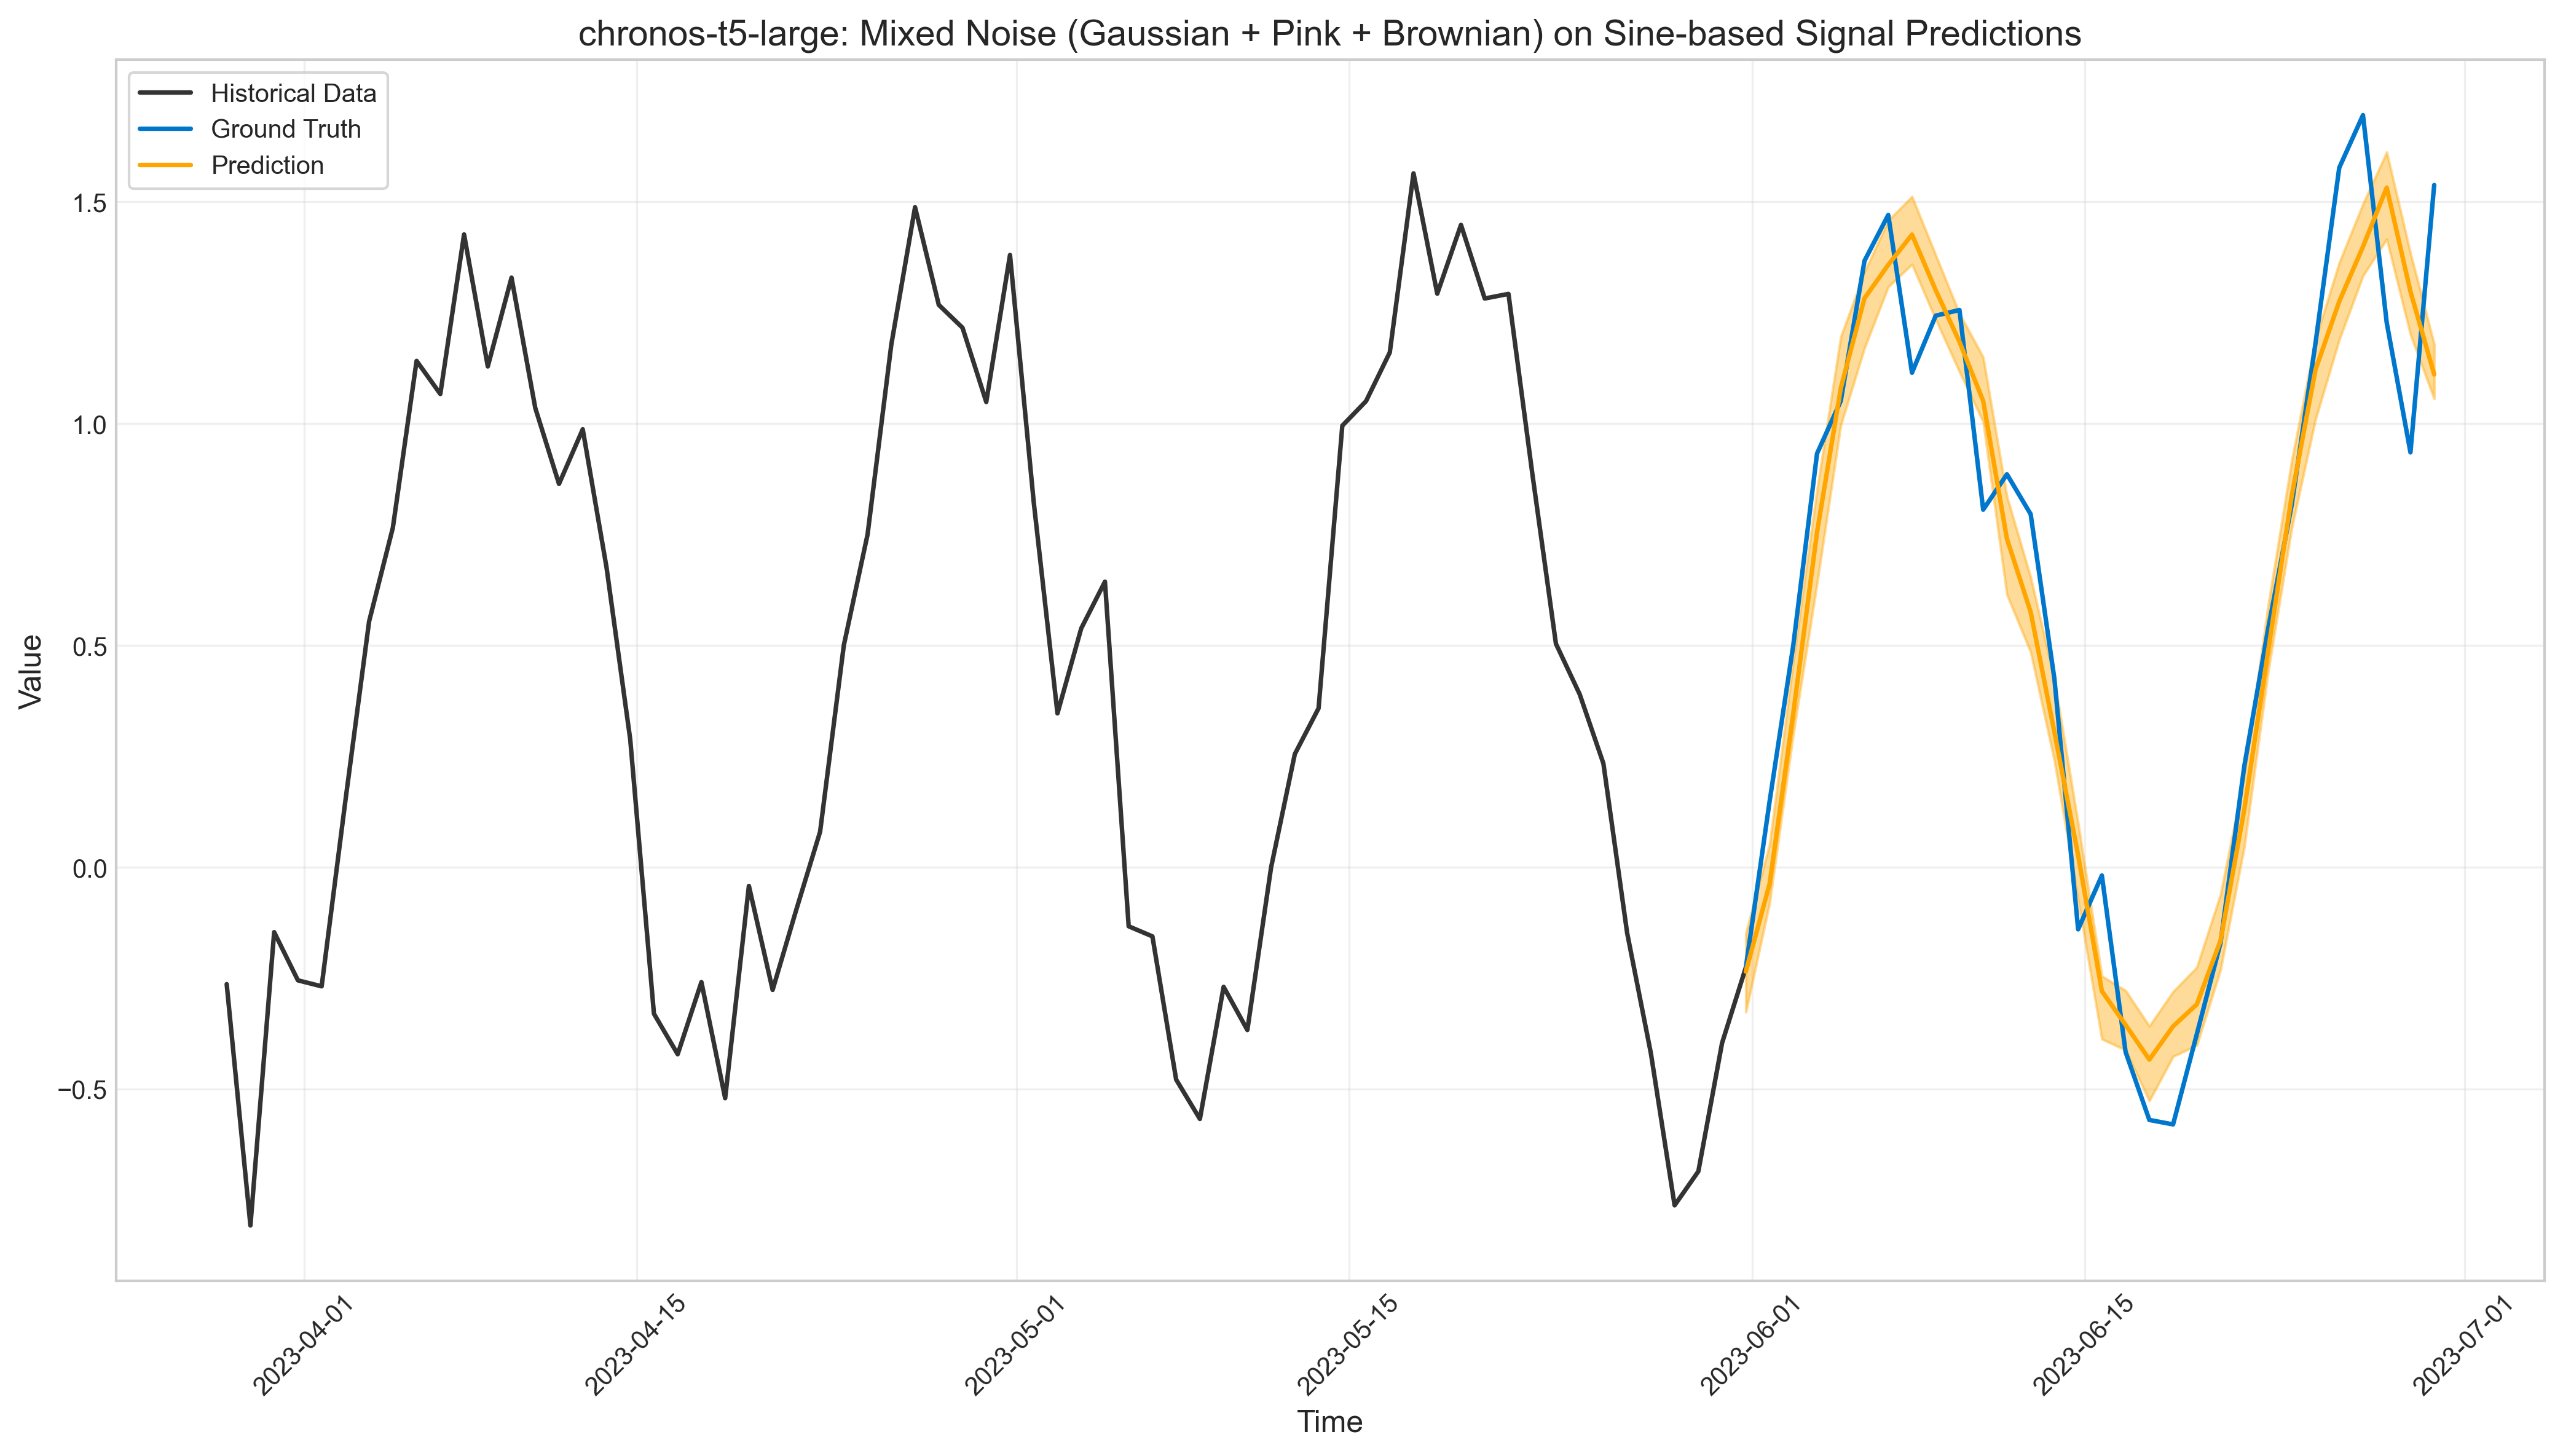

In [32]:
from data.synthetic.noise import MixedNoiseGenerator

mixed_gen = MixedNoiseGenerator(
    seq_length=2000,
    num_samples=1,
    base_signal="sine",
    seed=42,
)
mixed_data = mixed_gen.generate()

mixed_df = convert_synthetic_to_dataframe(mixed_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_mixeddf = mixed_df[mixed_df['Date'] <= test_date].index
test_start = date_indices_mixeddf[-1]

# Run Chronos comparison
mixed_df_chronos_avg, mixed_df_chronos_std, mixed_df_chronos_preds = run_multiple_trials_comparison(
    mixed_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in mixed_df_chronos_avg:
    print(f"{metric}: {mixed_df_chronos_avg[metric]:.4f} ± {mixed_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(mixed_df, test_start, mixed_df_chronos_preds, "chronos-t5-large: Mixed Noise (Gaussian + Pink + Brownian) on Sine-based Signal Predictions", historical_window=64, FORECAST_STEPS=30)

## 12. Mixed Noise (Gaussina + Pink + Brownian + Heavy-tailed) on Sine-based Signal


Trial 1/5
Context scaling metrics: {'MAE': 0.20816405996192527, 'MSE': 0.07143176145740646, 'RMSE': 0.2672672098432699, 'Z-NormalizedMAE': 0.2958626874235305, 'Z-NormalizedMSE': 0.14429798146801265, 'Z-NormalizedRMSE': 0.3798657413718861, 'MAPE': 31.029187143851285, 'SMAPE': 36.67043478191448, 'MASE': 0.5782141424233638, 'DirectionalAccuracy': 76.66666666666667}

Trial 2/5
Context scaling metrics: {'MAE': 0.19811620032547944, 'MSE': 0.06544725355760427, 'RMSE': 0.25582660838467186, 'Z-NormalizedMAE': 0.2815817075298975, 'Z-NormalizedMSE': 0.13220878763599783, 'Z-NormalizedRMSE': 0.36360526348775235, 'MAPE': 29.173982004535503, 'SMAPE': 35.351869027336875, 'MASE': 0.5503043555757182, 'DirectionalAccuracy': 73.33333333333333}

Trial 3/5
Context scaling metrics: {'MAE': 0.20824051922343104, 'MSE': 0.06844148745528278, 'RMSE': 0.2616132402140281, 'Z-NormalizedMAE': 0.29597135864464164, 'Z-NormalizedMSE': 0.13825738420792671, 'Z-NormalizedRMSE': 0.3718297785384149, 'MAPE': 30.8048426487535

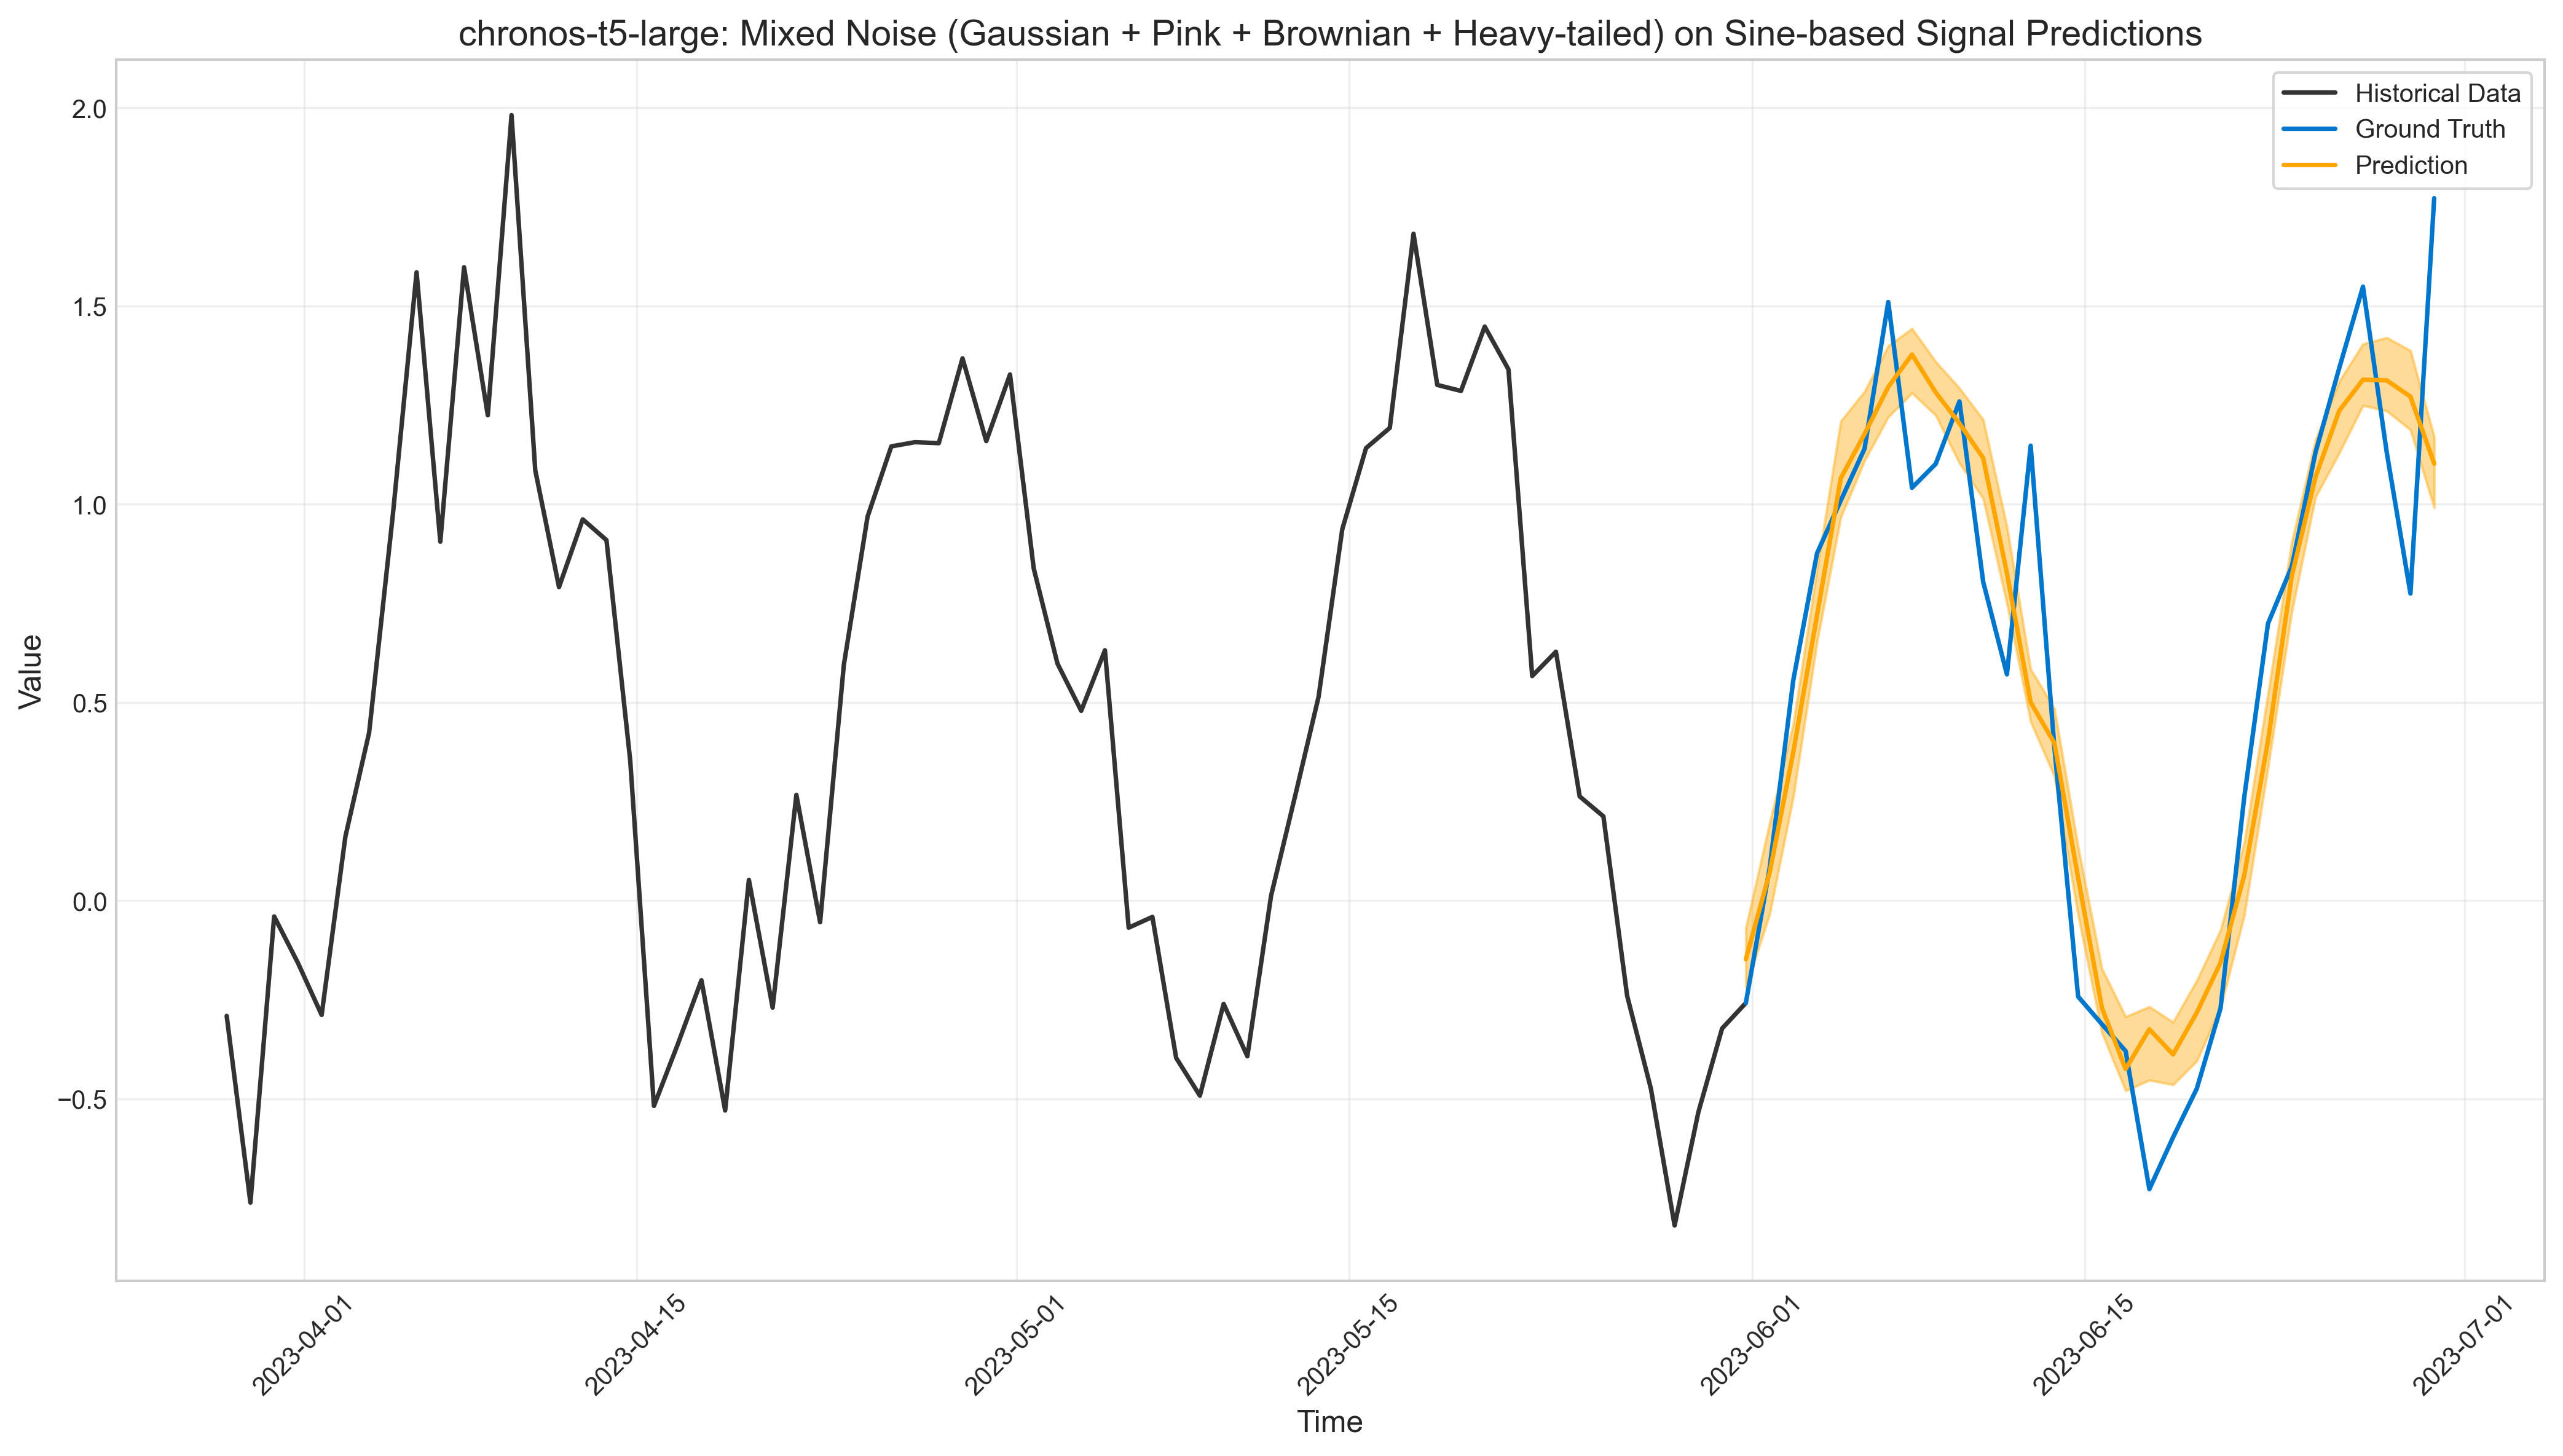

In [7]:
from data.synthetic.noise import MixedNoiseGenerator

mixed_gen = MixedNoiseGenerator(
    seq_length=2000,
    num_samples=1,
    base_signal="sine",
    seed=42,
)
mixed_data = mixed_gen.generate()

mixed_df = convert_synthetic_to_dataframe(mixed_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_mixeddf = mixed_df[mixed_df['Date'] <= test_date].index
test_start = date_indices_mixeddf[-1]

# Run Chronos comparison
mixed_df_chronos_avg, mixed_df_chronos_std, mixed_df_chronos_preds = run_multiple_trials_comparison(
    mixed_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in mixed_df_chronos_avg:
    print(f"{metric}: {mixed_df_chronos_avg[metric]:.4f} ± {mixed_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(mixed_df, test_start, mixed_df_chronos_preds, "chronos-t5-large: Mixed Noise (Gaussian + Pink + Brownian + Heavy-tailed) on Sine-based Signal Predictions", historical_window=64, FORECAST_STEPS=30)

### Here we obvserve something intuiative and allows us to identify the gap fot better predictions, when we add patterns like heavy-tailed or non-stationary to a signal where our predictions are completely off, it deminishes the overall prediction. So if we are able to adress the signals that we are bad at predicting, we can improve performance on more complicated signals.

# Varying Volatility and Statistical Patterns

## 13. High Mean


Trial 1/5
Context scaling metrics: {'MAE': 0.08366053258332139, 'MSE': 0.011146607943459612, 'RMSE': 0.10557749733470485, 'Z-NormalizedMAE': 0.12310866916136358, 'Z-NormalizedMSE': 0.024136747606191156, 'Z-NormalizedRMSE': 0.15536005794988347, 'MAPE': 0.8199056624830029, 'SMAPE': 0.8212259544915711, 'MASE': 0.3957171514563578, 'DirectionalAccuracy': 83.33333333333334}

Trial 2/5
Context scaling metrics: {'MAE': 0.08722323643322127, 'MSE': 0.011723460028907158, 'RMSE': 0.10827492797922868, 'Z-NormalizedMAE': 0.12835128137089524, 'Z-NormalizedMSE': 0.025385857044970876, 'Z-NormalizedRMSE': 0.15932939793073617, 'MAPE': 0.8524816372762442, 'SMAPE': 0.8536434115585311, 'MASE': 0.4125688612821454, 'DirectionalAccuracy': 86.66666666666667}

Trial 3/5
Context scaling metrics: {'MAE': 0.0750442250949027, 'MSE': 0.009216365763478786, 'RMSE': 0.09600190499921753, 'Z-NormalizedMAE': 0.11042954657834783, 'Z-NormalizedMSE': 0.019957021491004836, 'Z-NormalizedRMSE': 0.14126932254033372, 'MAPE': 0.73

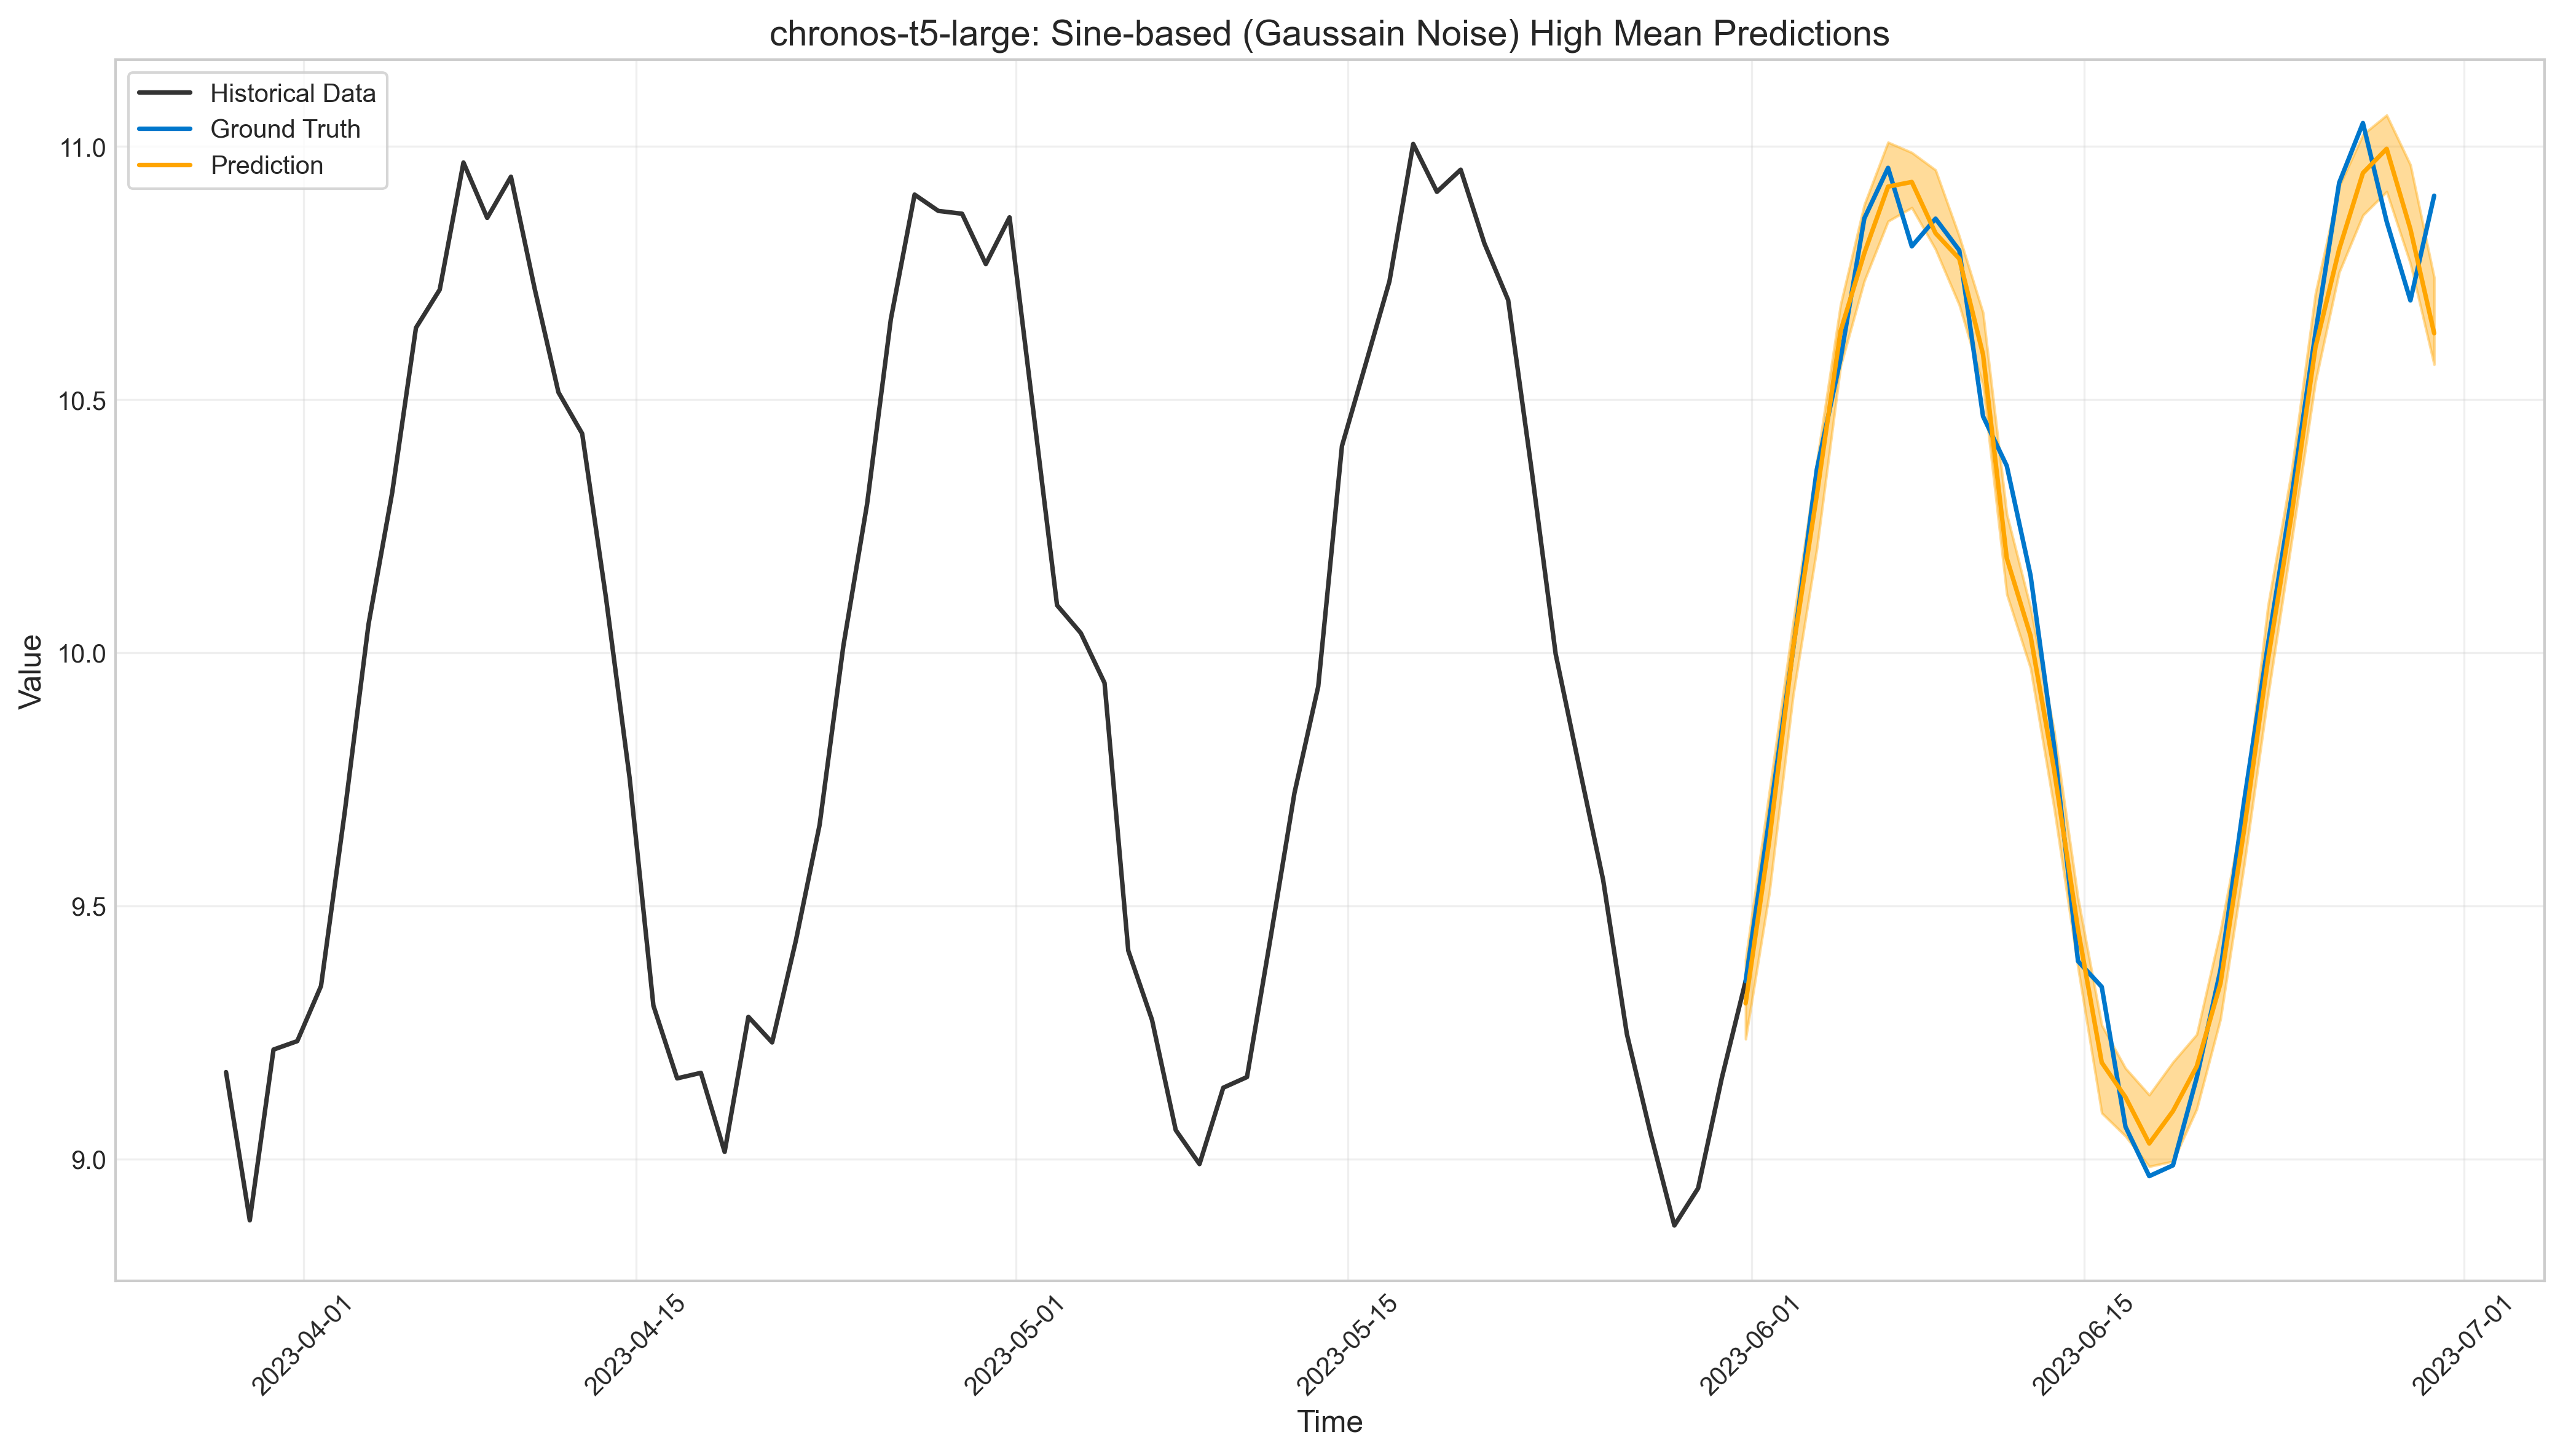

In [7]:
from data.synthetic.statistical_patterns import VaryingMeanGenerator 

highmean_gen = VaryingMeanGenerator(
    seq_length=2000,
    num_samples=1,
    mean_level="high",
    seasonal=True,
    seed=42,
)
highmean_data = highmean_gen.generate()

highmean_df = convert_synthetic_to_dataframe(highmean_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_highmeandf = highmean_df[highmean_df['Date'] <= test_date].index
test_start = date_indices_highmeandf[-1]

# Run Chronos comparison
highmean_df_chronos_avg, highmean_df_chronos_std, highmean_df_chronos_preds = run_multiple_trials_comparison(
    highmean_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in highmean_df_chronos_avg:
    print(f"{metric}: {highmean_df_chronos_avg[metric]:.4f} ± {highmean_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(highmean_df, test_start, highmean_df_chronos_preds, "chronos-t5-large: Sine-based (Gaussain Noise) High Mean Predictions", historical_window=64, FORECAST_STEPS=30)

## 14. Low Mean


Trial 1/5
Context scaling metrics: {'MAE': 0.07914829897110612, 'MSE': 0.01051798346519244, 'RMSE': 0.10255722044396699, 'Z-NormalizedMAE': 0.11646879898851056, 'Z-NormalizedMSE': 0.022775530772516546, 'Z-NormalizedRMSE': 0.15091564124542078, 'MAPE': 0.8203346188569206, 'SMAPE': 0.81903809902485, 'MASE': 0.37437413370837574, 'DirectionalAccuracy': 86.66666666666667}

Trial 2/5
Context scaling metrics: {'MAE': 0.0785316453688754, 'MSE': 0.010457737493669518, 'RMSE': 0.10226307981705576, 'Z-NormalizedMAE': 0.11556137703027025, 'Z-NormalizedMSE': 0.022645074779418507, 'Z-NormalizedRMSE': 0.15048280559392327, 'MAPE': 0.8086106521300241, 'SMAPE': 0.8069329691852286, 'MASE': 0.37145734129294367, 'DirectionalAccuracy': 86.66666666666667}

Trial 3/5
Context scaling metrics: {'MAE': 0.08771790204704276, 'MSE': 0.011448434215207063, 'RMSE': 0.1069973561131632, 'Z-NormalizedMAE': 0.1290791948029165, 'Z-NormalizedMSE': 0.024790319040571825, 'Z-NormalizedRMSE': 0.157449417403088, 'MAPE': 0.9067971

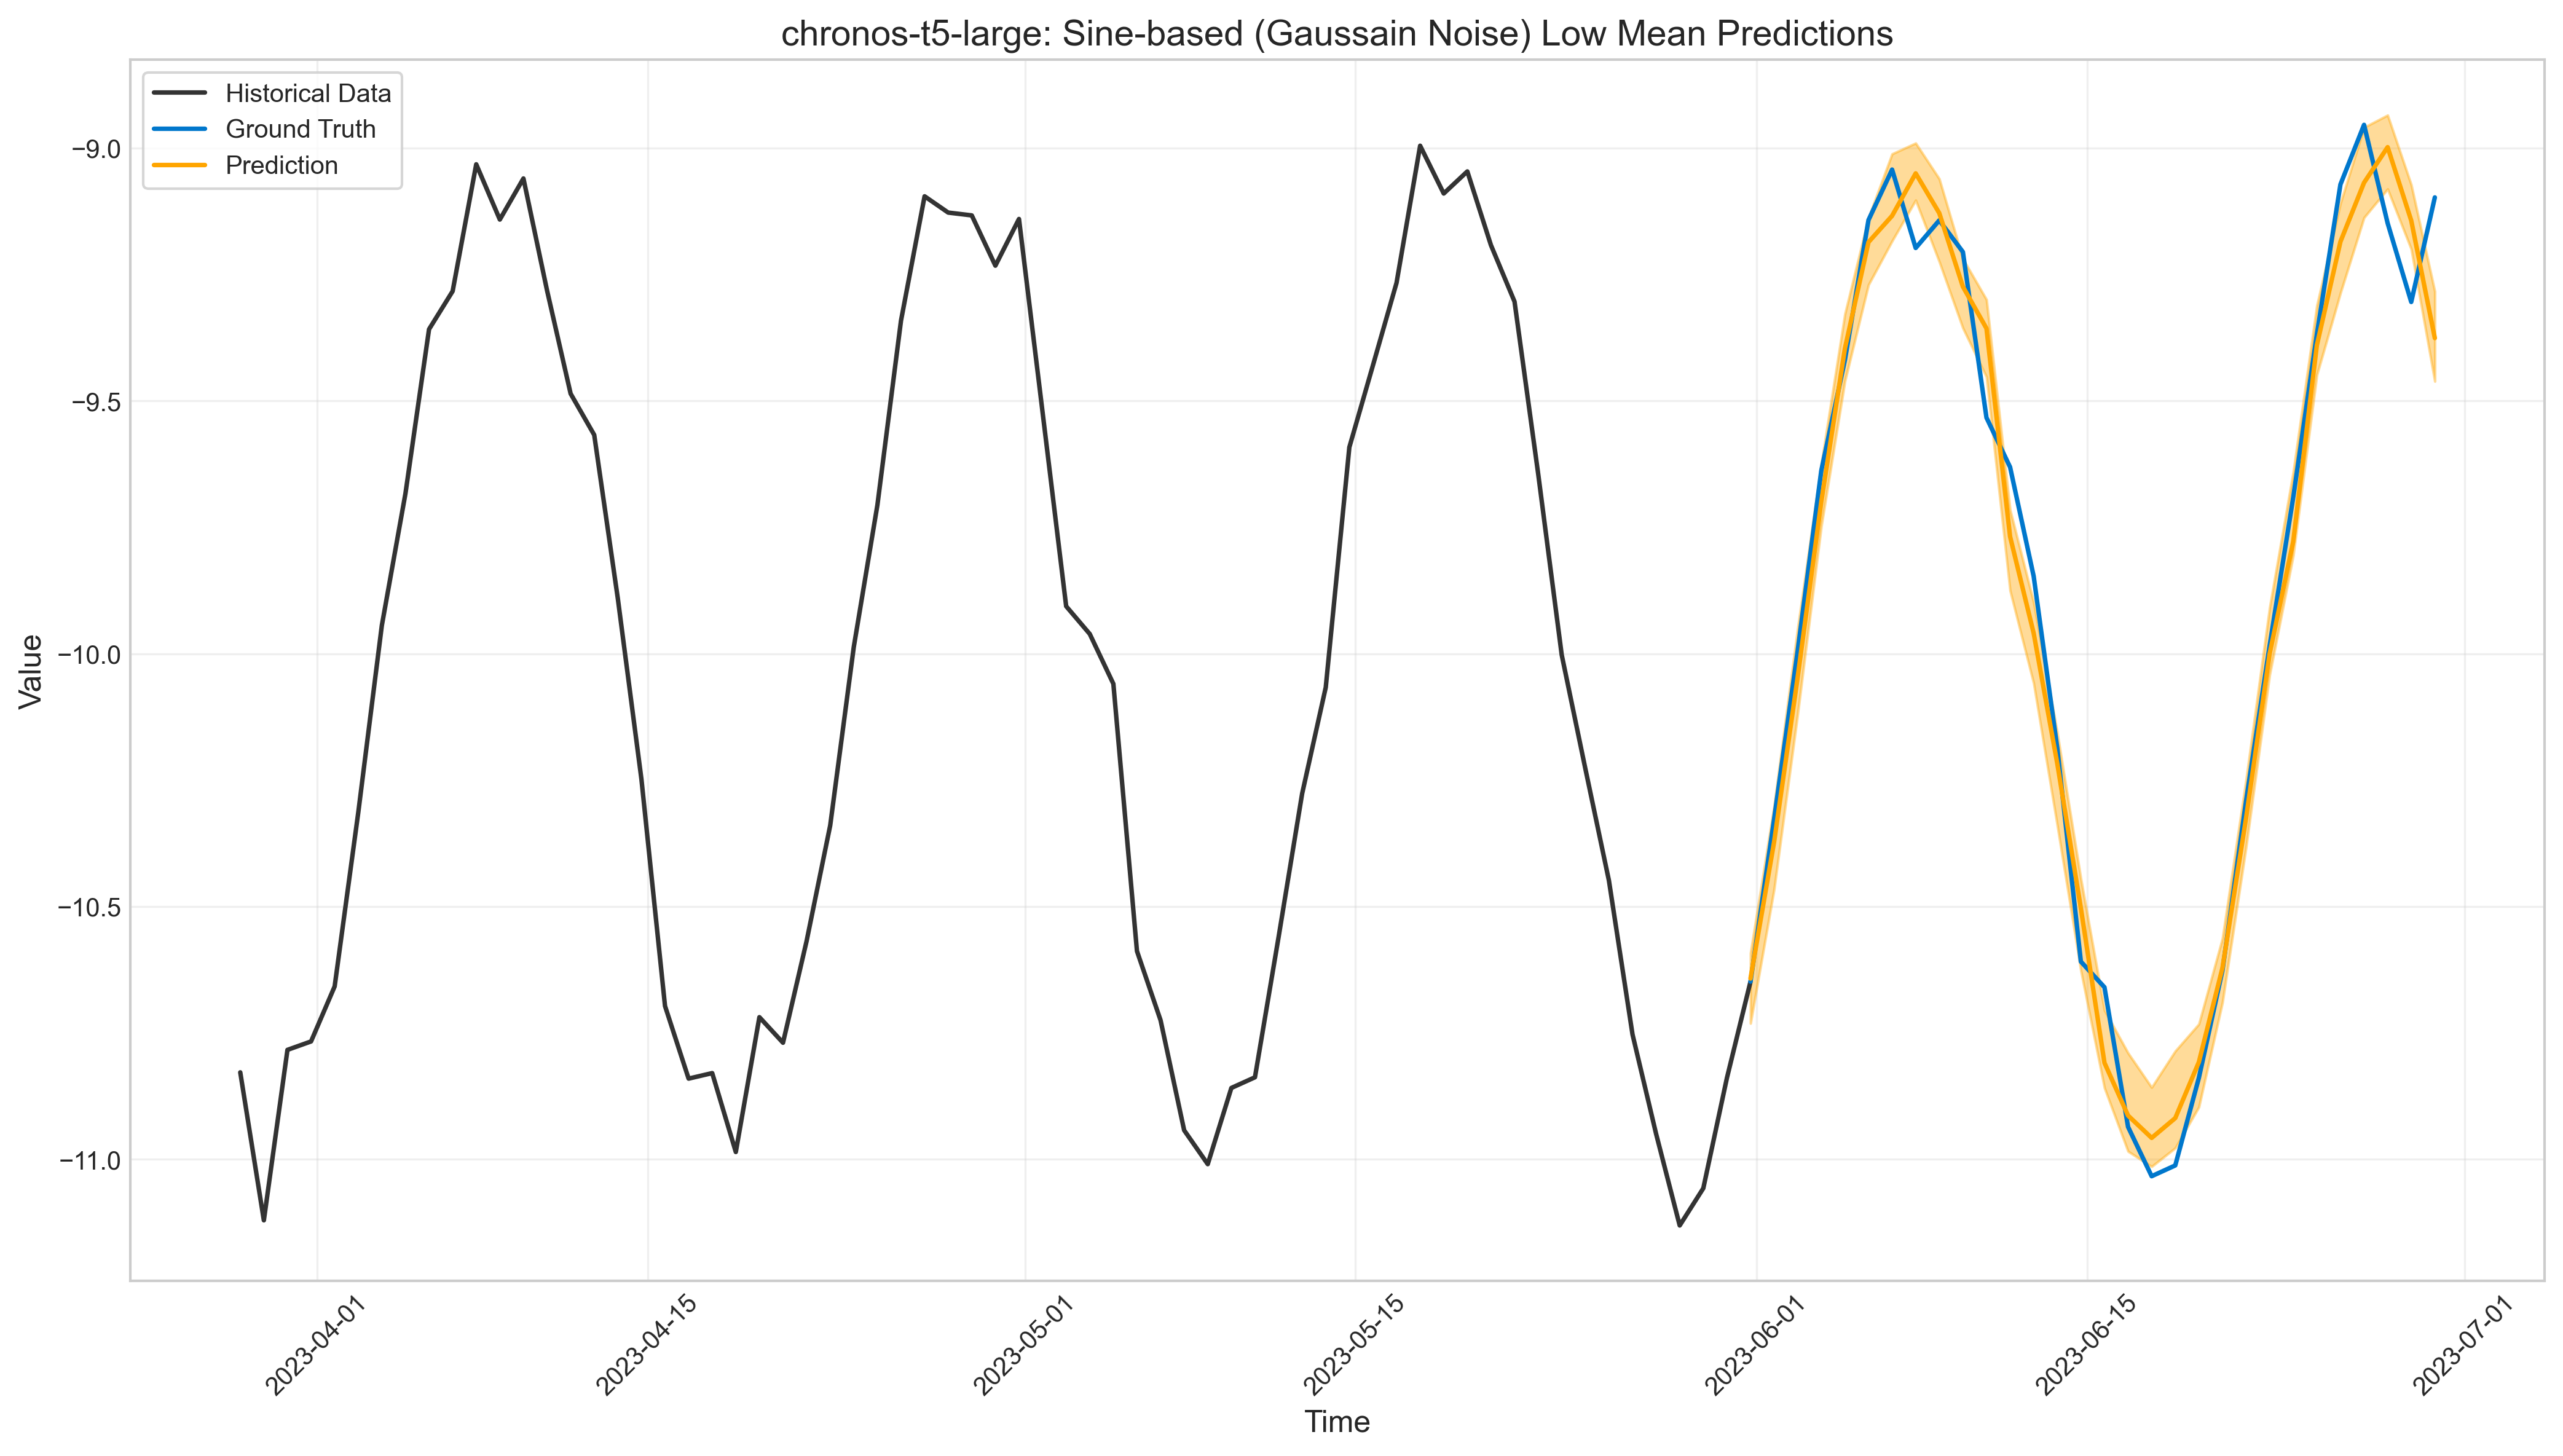

In [8]:
from data.synthetic.statistical_patterns import VaryingMeanGenerator 

lowmean_gen = VaryingMeanGenerator(
    seq_length=2000,
    num_samples=1,
    mean_level="low",
    seasonal=True,
    seed=42,
)
lowmean_data = lowmean_gen.generate()

lowmean_df = convert_synthetic_to_dataframe(lowmean_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_lowmeandf = lowmean_df[lowmean_df['Date'] <= test_date].index
test_start = date_indices_lowmeandf[-1]

# Run Chronos comparison
lowmean_df_chronos_avg, lowmean_df_chronos_std, lowmean_df_chronos_preds = run_multiple_trials_comparison(
    lowmean_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in lowmean_df_chronos_avg:
    print(f"{metric}: {lowmean_df_chronos_avg[metric]:.4f} ± {lowmean_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(lowmean_df, test_start, lowmean_df_chronos_preds, "chronos-t5-large: Sine-based (Gaussain Noise) Low Mean Predictions", historical_window=64, FORECAST_STEPS=30)

## 15. Varying Mean

In [ ]:
from data.synthetic.statistical_patterns import VaryingMeanGenerator 

varyingmean_gen = VaryingMeanGenerator(
    seq_length=2000,
    num_samples=1,
    mean_level="varying",
    seasonal=True,
    seed=42,
)
varyingmean_data = varyingmean_gen.generate()

varyingmean_df = convert_synthetic_to_dataframe(varyingmean_data)

# Select test start date
test_date_str = "2023-06-01"
test_date = pd.Timestamp(test_date_str)
date_indices_varyingmeandf = varyingmean_df[varyingmean_df['Date'] <= test_date].index
test_start = date_indices_varyingmeandf[-1]

# Run Chronos comparison
varyingmean_df_chronos_avg, varyingmean_df_chronos_std, varyingmean_df_chronos_preds = run_multiple_trials_comparison(
    varyingmean_df, 
    n_trials=5, 
    test_start=test_start,
    CONTEXT_WINDOW=120,
    FORECAST_STEPS=30
)

print("\nChronos T5 Context Scaling Metrics (Average ± Std):")
for metric in varyingmean_df_chronos_avg:
    print(f"{metric}: {varyingmean_df_chronos_avg[metric]:.4f} ± {varyingmean_df_chronos_std[metric]:.4f}")

# Plot results using the new high-quality plot_forecasts function (assumed to be defined elsewhere)
plot_forecasts(varyingmean_df, test_start, varyingmean_df_chronos_preds, "chronos-t5-large: Sine-based (Gaussain Noise) Varying Mean Predictions", historical_window=64, FORECAST_STEPS=30)